In [1]:
import uuid, sys, os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast
import math
import random

from sklearn import metrics
from scipy import stats
from collections import Counter

os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
torch.cuda.set_device(0)  # 0 == "first visible" -> actually GPU 2 on the node
print(torch.cuda.get_device_name(0))

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, WeightedRandomSampler, RandomSampler
import pytorch_lightning as pl
from torch.optim import AdamW

torch.manual_seed(0)

from accelerate import Accelerator

import matplotlib.pyplot as plt
import seaborn as sns

Tesla V100-SXM2-32GB


/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'Could not load this library: /work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/torchvision/image.so'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/work3/s232958/envs/esm_cuda/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
SEED = 0
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: s232958 (s232958-danmarks-tekniske-universitet-dtu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
os.chdir("/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts")
# print(os.getcwd())

print("PyTorch:", torch.__version__)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print("Current location:", os.getcwd())

PyTorch: 2.9.1+cu128
Using device: cuda
Current location: /zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts


In [5]:
# Model parameters
memory_verbose = False
use_wandb = True # Used to track loss in real-time without printing
model_save_steps = 1

embedding_dimension = 1152 # 1280 | 960 | 1152
number_of_recycles = 2
padding_value = -5000

In [6]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value
        self.embed_dimension = embed_dimension

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init

        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)  # For residual additions

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(max=100.0)
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        
        return logits

    def training_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        
        # compute on TRAIN fold
        # pos = (binder_labels == 1).sum()
        # neg = (binder_labels == 0).sum()
        # pos_weight = torch.tensor([neg / max(1, pos)], device=device)
        
        loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)

        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

In [7]:
## Output path
trained_model_dir = "/zhome/c9/0/203261/DBL046_PP_osaul/DBL046_PP_osaul/tmp/ona_drafts"

# ## Training variables
runID = uuid.uuid4()

def print_mem_consumption():
    # 1. Total memory available on the GPU (device 0)
    t = torch.cuda.get_device_properties(0).total_memory
    # 2. How much memory PyTorch has *reserved* from CUDA
    r = torch.cuda.memory_reserved(0)
    # 3. How much of that reserved memory is actually *used* by tensors
    a = torch.cuda.memory_allocated(0)
    # 4. Reserved but not currently allocated (so “free inside PyTorch’s pool”)
    f = r - a

    print("Total memory: ", t/1e9)      # total VRAM in GB
    print("Reserved memory: ", r/1e9)   # PyTorch’s reserved pool in GB
    print("Allocated memory: ", a//1e9) # actually in use (integer division)
    print("Free memory: ", f/1e9)       # slack in the reserved pool in GB
print_mem_consumption()

Total memory:  34.072559616
Reserved memory:  0.0
Allocated memory:  0.0
Free memory:  0.0


#### Loading data frame

In [8]:
### Loading the dataset
interaction_df = pd.read_csv("/work3/s232958/data/meta_analysis/interaction_df_metaanal.csv", index_col = 0).reset_index(drop=True).drop(columns = ["target_id"]).rename(columns={
    "A_seq" : "binder_seq",
    "B_seq" : "target_seq"
})

all_targets = interaction_df.target_id_mod.unique()
binder_nonbinder = interaction_df.binder.value_counts()
target_binder_nonbinder_Dict = dict(interaction_df.groupby("target_id_mod")["binder"].value_counts())
sorted_items = sorted(target_binder_nonbinder_Dict.items(), key=lambda kv: kv[1], reverse=True)

# %%
# Annotating each observation with a weight corresponding to whether it is considered a binder or not

### Weights for binder/non-binders
N_bins = len(interaction_df["binder"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["binder"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["class_weight"] = interaction_df.binder.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])
# binder_nonbinder_weights_Dict = dict(zip(interaction_df["target_binder_ID"], interaction_df["class_weight"]))

### Weights for target
N_bins = len(interaction_df["target_id_mod"].value_counts())
pr_class_uniform_weight = 1 / N_bins
pr_class_weight_informed_with_size_of_bins = pr_class_uniform_weight  / interaction_df["target_id_mod"].value_counts()
pr_class_weight_informed_with_size_of_bins = pr_class_weight_informed_with_size_of_bins.to_dict()
interaction_df["target_weight"] = interaction_df.target_id_mod.apply(lambda x: pr_class_weight_informed_with_size_of_bins[x])

### Combined weights
interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553


## 5-fold CV training + weighting of samples

In [9]:
clusters = [
    ["VirB8"], 
    ["FGFR2"], 
    ["IL7Ra"], 
    ["InsulinR"],
    ["EGFR", "EGFR_2", "EGFR_3"],     # keep together
    ["SARS_CoV2_RBD"], 
    ["Pdl1"], 
    ["TrkA"], 
    ["IL10Ra"],
    ["LTK"], 
    ["Mdm2"],
    ["sntx", "sntx_2"],               # keep together
    ["IL2Ra"]]

random.Random(0).shuffle(clusters)
folds = np.array_split(np.array(clusters, dtype=object), 5)   # list of np arrays
targets_folds = []
for f in folds:
    flat = []
    for group in f:
        flat.extend(group)
    targets_folds.append(flat)

def build_cv_splits(targets_folds):
    val_folds, train_folds = [], []
    K = len(targets_folds)
    for i in range(K):
        val_targets = list(targets_folds[i])  # copy
        train_targets = [t for j, fold in enumerate(targets_folds) if j != i for t in fold]
        val_folds.append(val_targets)
        train_folds.append(train_targets)
    return val_folds, train_folds

val_folds, train_folds = build_cv_splits(targets_folds)
cv_splits = list(zip(val_folds, train_folds))

In [10]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    vals = len(interaction_df[interaction_df.target_id_mod.isin(val_targets)])
    trains = len(interaction_df) - vals
    print(f"Fold {idx+1} : training instances : {trains}, validation instances : {vals}")

Fold 1 : training instances : 1280, validation instances : 2252
Fold 2 : training instances : 3213, validation instances : 319
Fold 3 : training instances : 3265, validation instances : 267
Fold 4 : training instances : 2999, validation instances : 533
Fold 5 : training instances : 3371, validation instances : 161


In [11]:
for idx in range(len(cv_splits)):
    val_targets = cv_splits[idx][0]
    train_targets = cv_splits[idx][1]
    print(f"Fold {idx+1} : validation targets : {val_targets}")

Fold 1 : validation targets : ['FGFR2', 'Mdm2', 'LTK']
Fold 2 : validation targets : ['SARS_CoV2_RBD', 'sntx', 'sntx_2', 'IL7Ra']
Fold 3 : validation targets : ['InsulinR', 'TrkA', 'IL10Ra']
Fold 4 : validation targets : ['EGFR', 'EGFR_2', 'EGFR_3', 'VirB8']
Fold 5 : validation targets : ['IL2Ra', 'Pdl1']


In [12]:
interaction_df.loc[interaction_df.target_id_mod.isin(cv_splits[1][1])].binder.value_counts()

binder
False    2876
True      337
Name: count, dtype: int64

#### Creating separate targets/ binder dataframes

In [13]:
# Targets df
target_df = interaction_df[["target_id_mod","target_seq"]].rename(columns={"target_seq":"sequence", "target_id_mod" : "ID"})
target_df["seq_len"] = target_df["sequence"].apply(len)
target_df = target_df.drop_duplicates(subset=["ID","sequence"])
target_df = target_df.set_index("ID")

# Binders df
binder_df = interaction_df[["target_binder_ID","binder_seq", "binder", "class_weight", "target_weight", "combined_weight"]].rename(columns={"binder_seq":"sequence", "target_binder_ID" : "ID", "binder" : "label"})
binder_df["seq_len"] = binder_df["sequence"].apply(len)
binder_df = binder_df.set_index("ID")

# Interaction Dict
interaction_Dict = dict(enumerate(zip(interaction_df["target_id_mod"], interaction_df["target_binder_ID"]), start=1))

In [14]:
class CLIP_meta_analysis_dataset(Dataset):

    def __init__(self, sequence_df, esm_encoding_paths, embedding_dim=1152, padding_value=-5000):

        super(CLIP_meta_analysis_dataset, self).__init__()

        self.sequence_df = sequence_df # target/binder_df
        self.max_length = sequence_df["seq_len"].max()+2
        self.sequence_df["index_num"] = np.arange(len(self.sequence_df))
        # print(self.sequence_df)
        self.esm_encoding_paths = esm_encoding_paths
        num_samples = len(self.sequence_df)
        
        self.x = torch.full((num_samples, self.max_length, embedding_dim), padding_value, dtype=torch.float32)

        self.accessions = self.sequence_df.index.astype(str).tolist()
        self.name_to_row = {name: i for i, name in enumerate(self.accessions)}
        
        # Load embeddings into the pre-allocated tensor
        all_acc_list = self.accessions
        all_acc_loaded_list = []

        iterator = tqdm(all_acc_list, position=0, leave=True, total=num_samples, desc="# Reading in ESM-embeddings from folder")
        for i, accession in enumerate(iterator):
            npy_path = os.path.join(esm_encoding_paths, f"{accession}.npy")
            try:
                embd = np.load(npy_path)[0]
                assert (embd.shape[0] == self.sequence_df.loc[accession].seq_len+2)
                length_to_pad = self.max_length - len(embd)
                if length_to_pad > 0:
                    zero_padding = np.ones((length_to_pad, embd.shape[1])) * padding_value
                    padded_array = np.concatenate((embd, zero_padding), axis=0)
                else:
                    padded_array = embd[:self.max_length] 
                self.x[i] = torch.tensor(padded_array, dtype=torch.float32)
                all_acc_loaded_list.append(accession)
            except FileNotFoundError as e:
                raise FileNotFoundError(f"Embedding file {accession}.npy not found.")
            
        missing = sorted(set(all_acc_list) - set(all_acc_loaded_list))
        if missing:
            raise FileNotFoundError(
                f"Missing {len(missing)} embedding files in '{esm_encoding_paths}'. "
                f"Examples: {missing}")
          
    def __len__(self):
        return int(self.x.shape[0])

    def __getitem__(self, idx):
        return self.x[idx]
    
    # add a helper:
    def get_by_name(self, name: str):
        return self.x[self.name_to_row[name]]

targets_dataset = CLIP_meta_analysis_dataset(target_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/embeddings_esmC_targets", embedding_dim=1152)
binders_dataset = CLIP_meta_analysis_dataset(binder_df, esm_encoding_paths="/work3/s232958/data/meta_analysis/embeddings_esmC_binders", embedding_dim=1152)

# Reading in ESM-embeddings from folder: 100%|█████████████████████████████████████| 3532/3532 [00:08<00:00, 425.27it/s]


In [15]:
# checking if _get_by_name function gives the same output as index used
print(torch.equal(targets_dataset[0], targets_dataset.get_by_name("VirB8")))
print(torch.equal(binders_dataset[0], binders_dataset.get_by_name("VirB8_1")))

True
True


### Loading pretrained model for finetuning

In [16]:
ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# print(list(checkpoint["model_state_dict"]))
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MiniCLIP_w_transformer_crossattn()
model.load_state_dict(checkpoint['model_state_dict'])
torch.cuda.empty_cache()  # frees cached blocks (not live tensors)
device = torch.device("cuda:0")
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

### Creating function for loading training/ vlaidation datasets
#### creating class for pairing minibinder_emb, target_emb, label

In [17]:
def binder_to_target_name(bname: str) -> str:
    parts = bname.split("_")
    if bname.startswith("SARS"):
        return "SARS_CoV2_RBD"
    if len(parts) == 3:
        return f"{parts[0]}_{parts[1]}"
    return parts[0]

def binder_target_label(targets_dataset, binders_dataset, binder_ids, interaction_df, stack=True):
    listof_bindertargetlabel = []
    for bname in binder_ids:
        tname = binder_to_target_name(bname)
        b_emb = binders_dataset.get_by_name(bname)
        t_emb = targets_dataset.get_by_name(tname)
        s = interaction_df.loc[interaction_df['target_binder_ID'] == bname, 'binder']
        lbl = torch.tensor(float(s.iat[0]), dtype=torch.float32)
        listof_bindertargetlabel.append((b_emb, t_emb, lbl))

    return listof_bindertargetlabel

ALL_btl_list = binder_target_label(targets_dataset, binders_dataset, interaction_df["target_binder_ID"].tolist(), interaction_df)
# ALL_btl_list.__len__()
# ALL_btl_list.__getitem__(0)

binders = torch.stack([torch.as_tensor(b) for b,_,_ in ALL_btl_list])   # [N, L, D]
targets = torch.stack([torch.as_tensor(t) for _,t,_ in ALL_btl_list])   # [N, L, D]
labels  = torch.tensor([float(y) for _,_,y in ALL_btl_list], dtype=torch.float32)  # [N]

ALL_btl = TensorDataset(binders, targets, labels)
# ALL_btl[0]

In [18]:
### Combined weights (boost positives, reduce number of FGFR2 binder)
multipliers = []
for name in interaction_df["target_id_mod"]:
    if name == "FGFR2":
        multipliers.append(1)
    else:
        multipliers.append(5)
interaction_df["target_weight_FGFR2_reduced"] = interaction_df["target_weight"] * multipliers

### Combined weights
# interaction_df["combined_weight"] = (interaction_df["class_weight"]+interaction_df["target_weight"])/2

### Combined weights (boost positives)
multipliers = []
for binder in interaction_df["binder"]:
    if binder == False:
        multipliers.append(1)
    else:
        multipliers.append(2)
interaction_df["combined_weight_boost_pos"] = ((interaction_df["class_weight"]+interaction_df["target_weight_FGFR2_reduced"])/2) * multipliers

In [19]:
interaction_df

,binder_chain,target_chains,binder,binder_seq,target_seq,target_id_mod,target_binder_ID,class_weight,target_weight,combined_weight,target_weight_FGFR2_reduced,combined_weight_boost_pos
0,A,"[""B""]",False,LDFIVFAGPEKAIKFYKEMAKRNLEVKIWIDGDWAVVQVK,ANPYISVANIMLQNYVKQREKYNYDTLKEQFTFIKNASTSIVYMQF...,VirB8,VirB8_1,0.000159,0.000631,0.000395,0.003157,0.001658
1,A,"[""B""]",False,SEQDETMHRIVRSVIQHAYKHNDEMAEYFAQNAAEIYKEQNKSEEA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_1,0.000159,0.000029,0.000094,0.000029,0.000094
2,A,"[""B""]",False,DYKQLKKHATKLLELAKKDPSSKRDLLRTAASYANKVLFEDSDPRA...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_2,0.000159,0.000029,0.000094,0.000029,0.000094
3,A,"[""B""]",False,DEKEELERRANRVAFLAIQIQNEEYHRILAELYVQFMKAAENNDTE...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_3,0.000159,0.000029,0.000094,0.000029,0.000094
4,A,"[""B""]",False,PDNKEKLMSIAVQLILRINEAARSEEQWRYANRAAFAAVEASSGSD...,RSPHRPILQAGLPANASTVVGGDVEFVCKVYSDAQPHIQWIKHVPY...,FGFR2,FGFR2_4,0.000159,0.000029,0.000094,0.000029,0.000094
...,...,...,...,...,...,...,...,...,...,...,...,...
3527,A,"[""B""]",False,DLRKYAAELVDRLAEKYNLDSDQYNALVRLASELVWQGKSKEEIEK...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_62,0.000159,0.000947,0.000553,0.004735,0.002447
3528,A,"[""B""]",False,SKEEIKKEAEELIEELKKKGYNLPLRILEFALKEIEETNSEKYYEQ...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_63,0.000159,0.000947,0.000553,0.004735,0.002447
3529,A,"[""B""]",False,SPEYKKFLELIKEAEAARKAGDLDKAKELLEKALELAKKMKAKSLI...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_64,0.000159,0.000947,0.000553,0.004735,0.002447
3530,A,"[""B""]",False,DPLLAYKLLKLSQKALEKAYAEDRERAEELLEEAEAALRSLGDEAG...,ELCDDDPPEIPHATFKAMAYKEGTMLNCECKRGFRRIKSGSLYMLC...,IL2Ra,IL2Ra_65,0.000159,0.000947,0.000553,0.004735,0.002447


In [20]:
assert labels.ndim == 1 and labels.shape[0] == binders.shape[0]
assert binders.dtype == targets.dtype
# assert binders.shape == targets.shape

In [21]:
u = interaction_df[['binder', 'target_id_mod', 'combined_weight_boost_pos']].drop_duplicates(subset=['target_id_mod', 'binder'])
print(u.sort_values('target_id_mod').to_string(index=False))
# or as a dict:
weight_map = u.set_index('target_id_mod')['combined_weight_boost_pos'].to_dict()

 binder target_id_mod  combined_weight_boost_pos
   True          EGFR                   0.003720
  False          EGFR                   0.001300
   True        EGFR_2                   0.002314
  False        EGFR_2                   0.000597
   True        EGFR_3                   0.079404
  False         FGFR2                   0.000094
   True         FGFR2                   0.001308
   True        IL10Ra                   0.015483
  False        IL10Ra                   0.007182
   True         IL2Ra                   0.006014
  False         IL2Ra                   0.002447
  False         IL7Ra                   0.000993
   True         IL7Ra                   0.003106
   True      InsulinR                   0.003950
  False      InsulinR                   0.001415
  False           LTK                   0.004814
   True           LTK                   0.010748
  False          Mdm2                   0.001707
   True          Mdm2                   0.004534
   True          Pdl

In [22]:
train_targets = cv_splits[1][1]
g = torch.Generator().manual_seed(SEED)

class PairListDataset(torch.utils.data.Dataset):
    # examples: list of (binder_emb, target_emb, label)
    # target_ids: parallel list of target_id_mod (same order)
    def __init__(self, examples, target_ids):
        assert len(examples) == len(target_ids)
        self.examples = examples
        self.target_ids = list(map(str, target_ids))

    def __len__(self): return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        return (torch.as_tensor(b, dtype=torch.float32),
                torch.as_tensor(t, dtype=torch.float32),
                torch.tensor(float(y), dtype=torch.float32),
                self.target_ids[idx])  # <- keep the id

train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
# train_weights_combined_boosted = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
train_target_ids = interaction_df.loc[train_idx, "target_id_mod"].astype(str).tolist()
train_binders_ds = PairListDataset([ALL_btl[idx] for idx in train_idx], target_ids=train_target_ids)

train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=len(train_binders_ds), replacement=True, generator = g)
train_loader   = DataLoader(train_binders_ds,  batch_size=20, sampler=train_sampler)

for bi, batch in enumerate(train_loader):
    _, _, labels, ids = batch
    c = Counter(ids)
    print(f"Batch {bi}: {dict(c)}  | positives={int(labels.sum().item())} / {labels.numel()}")
    if bi == 10: break  # first 5 batches

Batch 0: {'EGFR_2': 3, 'FGFR2': 11, 'Mdm2': 2, 'EGFR_3': 1, 'VirB8': 1, 'TrkA': 1, 'InsulinR': 1}  | positives=8 / 20
Batch 1: {'FGFR2': 12, 'TrkA': 1, 'InsulinR': 1, 'LTK': 2, 'Mdm2': 1, 'EGFR_2': 2, 'VirB8': 1}  | positives=11 / 20
Batch 2: {'FGFR2': 8, 'Mdm2': 3, 'Pdl1': 1, 'IL2Ra': 2, 'InsulinR': 2, 'EGFR_2': 1, 'TrkA': 2, 'VirB8': 1}  | positives=12 / 20
Batch 3: {'FGFR2': 11, 'IL2Ra': 1, 'VirB8': 2, 'EGFR': 2, 'Mdm2': 2, 'Pdl1': 1, 'LTK': 1}  | positives=8 / 20
Batch 4: {'EGFR_2': 1, 'FGFR2': 15, 'TrkA': 1, 'Mdm2': 1, 'VirB8': 1, 'InsulinR': 1}  | positives=5 / 20
Batch 5: {'FGFR2': 12, 'EGFR_2': 4, 'Mdm2': 2, 'VirB8': 1, 'TrkA': 1}  | positives=10 / 20
Batch 6: {'FGFR2': 11, 'Pdl1': 3, 'IL10Ra': 1, 'EGFR_2': 1, 'Mdm2': 1, 'EGFR_3': 1, 'InsulinR': 1, 'VirB8': 1}  | positives=13 / 20
Batch 7: {'FGFR2': 17, 'EGFR': 1, 'EGFR_2': 1, 'VirB8': 1}  | positives=10 / 20
Batch 8: {'Mdm2': 3, 'FGFR2': 10, 'InsulinR': 1, 'EGFR_2': 3, 'IL2Ra': 1, 'TrkA': 1, 'IL10Ra': 1}  | positives=11 / 20
B

### Training loop

In [23]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


all_hist = []


class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset,
                 optimizer, EPOCHS, runID, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False,
                 v=False, wandb_tracker=False, split_id=None):

        self.model = model
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        # for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
        for batch_data in self.training_loader:
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):

        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)

        with torch.no_grad():
            # for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
            for one_batch in batched_data:

                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

                logits = model.forward(binders, targets)

                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())

        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)

        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)

        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):

        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []

        with torch.no_grad():
            # for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
            for batch_data in dataloader:

                loss, logits, labels = self.model.validation_step(batch_data, self.device)

                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())

        val_loss = running_loss / max(1, n_loss)

        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")

        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):

        if not hist:
            return

        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))

        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]

        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]

            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()

        plt.tight_layout(); plt.show()

        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)

        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")

        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []

        # --- Epoch loop ---
        # for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
        for epoch in range(1, self.EPOCHS + 1):

            torch.cuda.empty_cache()

            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))

            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )

            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                median_pos = float(np.median(scores[pos_mask])) if pos_mask.any() else float("nan")
                median_neg = float(np.median(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = median_pos - median_neg if np.isfinite(median_pos) and np.isfinite(median_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")

            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_median_logit": median_pos,
                    "val_neg_median_logit": median_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)

        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)

        if self.wandb_tracker:
            self.wandb_tracker.finish()

## class weighting (12 epochs)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 0.5328 | Val Loss 0.5241 | Val AUROC 0.6435 | Val AUPR 0.2319
EPOCH 2 - Train Loss 0.3053 | Val Loss 0.4024 | Val AUROC 0.6447 | Val AUPR 0.2424
EPOCH 3 - Train Loss 0.1392 | Val Loss 0.3753 | Val AUROC 0.6116 | Val AUPR 0.2317
EPOCH 4 - Train Loss 0.0716 | Val Loss 0.4193 | Val AUROC 0.6371 | Val AUPR 0.2525
EPOCH 5 - Train Loss 0.0285 | Val Loss 0.4183 | Val AUROC 0.6250 | Val AUPR 0.2272
EPOCH 6 - Train Loss 0.0127 | Val Loss 0.4251 | Val AUROC 0.6153 | Val AUPR 0.2137
EPOCH 7 - Train Loss 0.0117 | Val Loss 0.4289 | Val AUROC 0.6185 | Val AUPR 0.2278
EPOCH 8 - Train Loss 0.0057 | Val Loss 0.4715 | Val AUROC 0.6028 | Val AUPR 0.2233
EPOCH 9 - Train Loss 0.0034 | Val Loss 0.4669 | Val AUROC 0.5968 | Val AUPR 0.2184
EPOCH 10 - Train Loss 0.0020 | Val Loss 0.4767 | Val AUROC 0.5979 | Val AUPR 0.2120
EPOCH 11 - Train Loss 0.0015 | Val Loss 0.4750

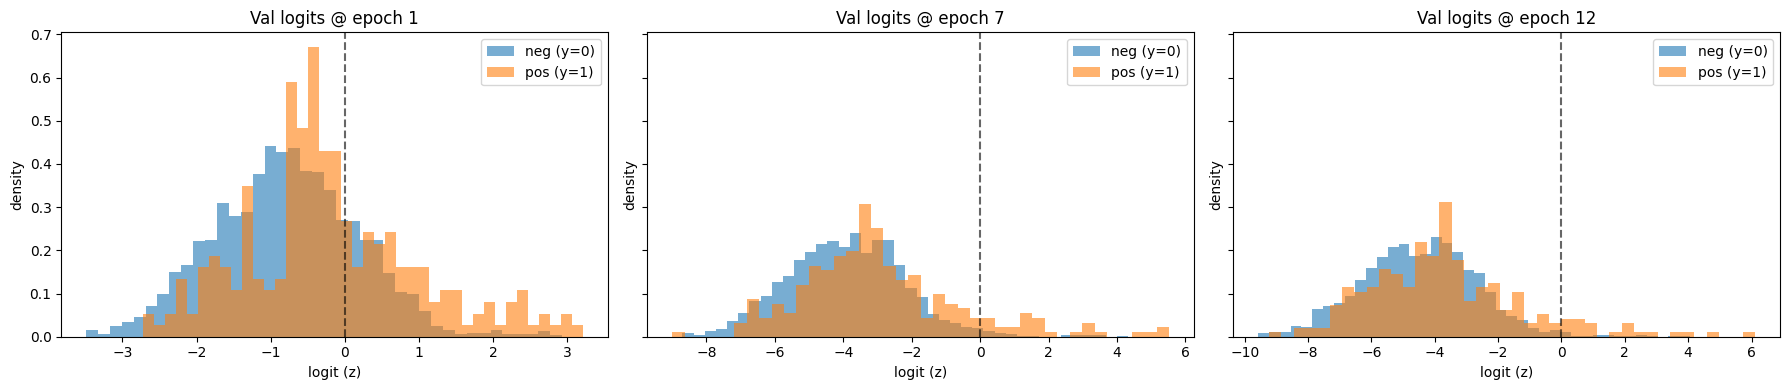

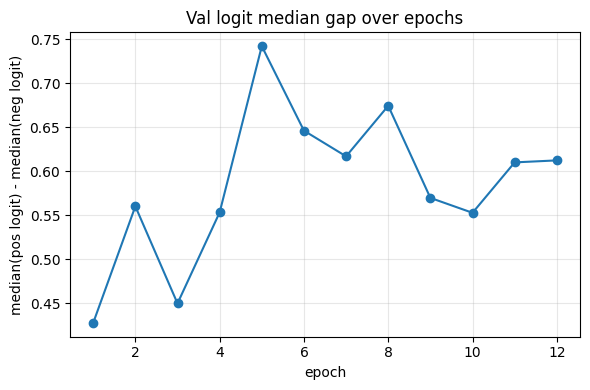

Train Loss,█▅▃▂▁▁▁▁▁▁▁▁
Val AUPR,▁▇▇▇█▇▆▇▆▆▆▆▆
Val AUROC,▁██▅▇▆▆▆▅▄▄▄▄
Val Loss,█▂▁▁▁▁▁▁▂▂▂▂▂
val_logit_gap,▁▄▁▄█▆▅▆▄▄▅▅
val_neg_median_logit,█▆▄▂▃▃▂▁▁▁▁▁
val_pos_median_logit,█▆▄▂▃▃▂▁▁▁▁▁
Train Loss,0.00137
Val AUPR,0.20882
Val AUROC,0.59055
Val Loss,0.47883


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 0.6021 | Val Loss 0.6016 | Val AUROC 0.5841 | Val AUPR 0.2223
EPOCH 2 - Train Loss 0.5399 | Val Loss 0.6452 | Val AUROC 0.6409 | Val AUPR 0.2804
EPOCH 3 - Train Loss 0.4709 | Val Loss 0.6685 | Val AUROC 0.5739 | Val AUPR 0.1932
EPOCH 4 - Train Loss 0.4119 | Val Loss 0.5287 | Val AUROC 0.6481 | Val AUPR 0.2907
EPOCH 5 - Train Loss 0.3418 | Val Loss 0.5118 | Val AUROC 0.6258 | Val AUPR 0.2730
EPOCH 6 - Train Loss 0.2455 | Val Loss 0.6270 | Val AUROC 0.5748 | Val AUPR 0.2245
EPOCH 7 - Train Loss 0.1905 | Val Loss 0.5750 | Val AUROC 0.5803 | Val AUPR 0.2451
EPOCH 8 - Train Loss 0.1006 | Val Loss 0.5886 | Val AUROC 0.6055 | Val AUPR 0.2594
EPOCH 9 - Train Loss 0.0810 | Val Loss 0.5931 | Val AUROC 0.5385 | Val AUPR 0.2289
EPOCH 10 - Train Loss 0.0624 | Val Loss 0.7482 | Val AUROC 0.4813 | Val AUPR 0.1920
EPOCH 11 - Train Loss 0.0411 | Val Loss 0.7187

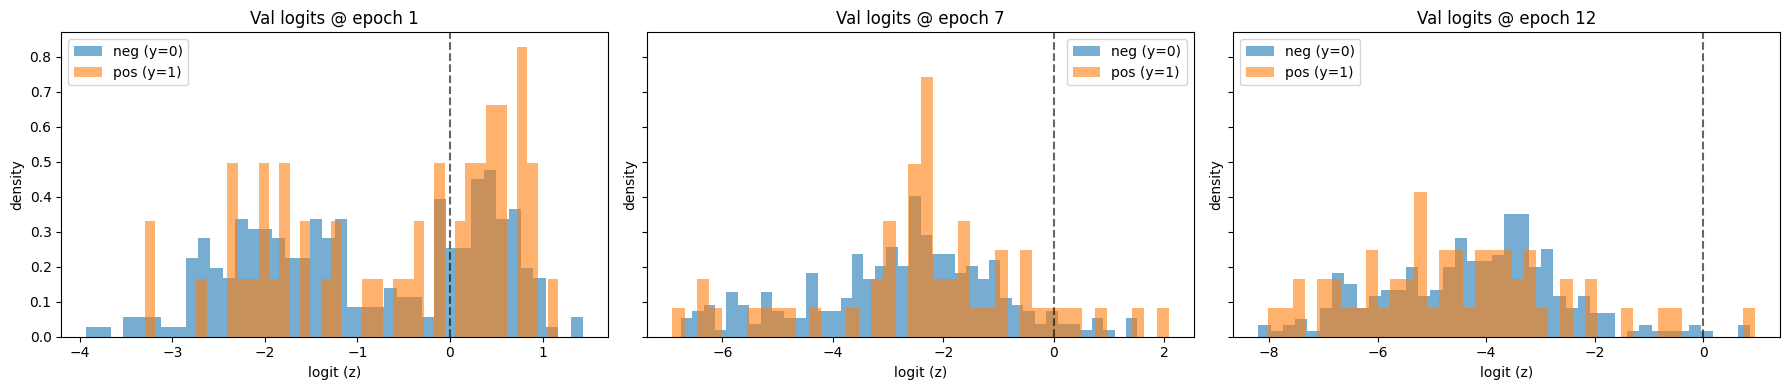

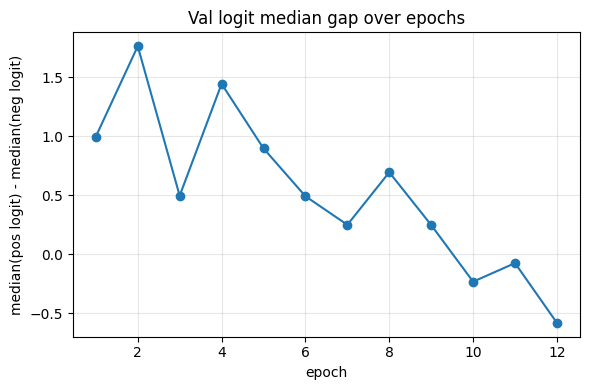

Train Loss,█▇▆▆▅▄▃▂▂▁▁▁
Val AUPR,▅▄▇▂█▇▄▅▆▄▂▃▁
Val AUROC,▇▆█▆█▇▆▆▇▄▃▃▁
Val Loss,█▂▃▃▁▁▂▂▂▂▄▃▅
val_logit_gap,▆█▄▇▅▄▃▅▃▂▃▁
val_neg_median_logit,█▇▄▅▅▃▅▃▄▁▂▁
val_pos_median_logit,▇█▄▆▅▃▄▄▄▂▂▁
Train Loss,0.02751
Val AUPR,0.17578
Val AUROC,0.43187
Val Loss,0.82677


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 0.6120 | Val Loss 0.5782 | Val AUROC 0.5767 | Val AUPR 0.1396
EPOCH 2 - Train Loss 0.5216 | Val Loss 0.8853 | Val AUROC 0.6448 | Val AUPR 0.1872
EPOCH 3 - Train Loss 0.4598 | Val Loss 0.5440 | Val AUROC 0.6193 | Val AUPR 0.1643
EPOCH 4 - Train Loss 0.4131 | Val Loss 0.5992 | Val AUROC 0.6311 | Val AUPR 0.1777
EPOCH 5 - Train Loss 0.3313 | Val Loss 0.5829 | Val AUROC 0.5865 | Val AUPR 0.1850
EPOCH 6 - Train Loss 0.2772 | Val Loss 0.5400 | Val AUROC 0.6042 | Val AUPR 0.1649
EPOCH 7 - Train Loss 0.1804 | Val Loss 0.6085 | Val AUROC 0.5999 | Val AUPR 0.1669
EPOCH 8 - Train Loss 0.1251 | Val Loss 0.5486 | Val AUROC 0.5928 | Val AUPR 0.1681
EPOCH 9 - Train Loss 0.0943 | Val Loss 0.6869 | Val AUROC 0.5672 | Val AUPR 0.1616
EPOCH 10 - Train Loss 0.0731 | Val Loss 0.5480 | Val AUROC 0.5865 | Val AUPR 0.1795
EPOCH 11 - Train Loss 0.0484 | Val Loss 0.5872

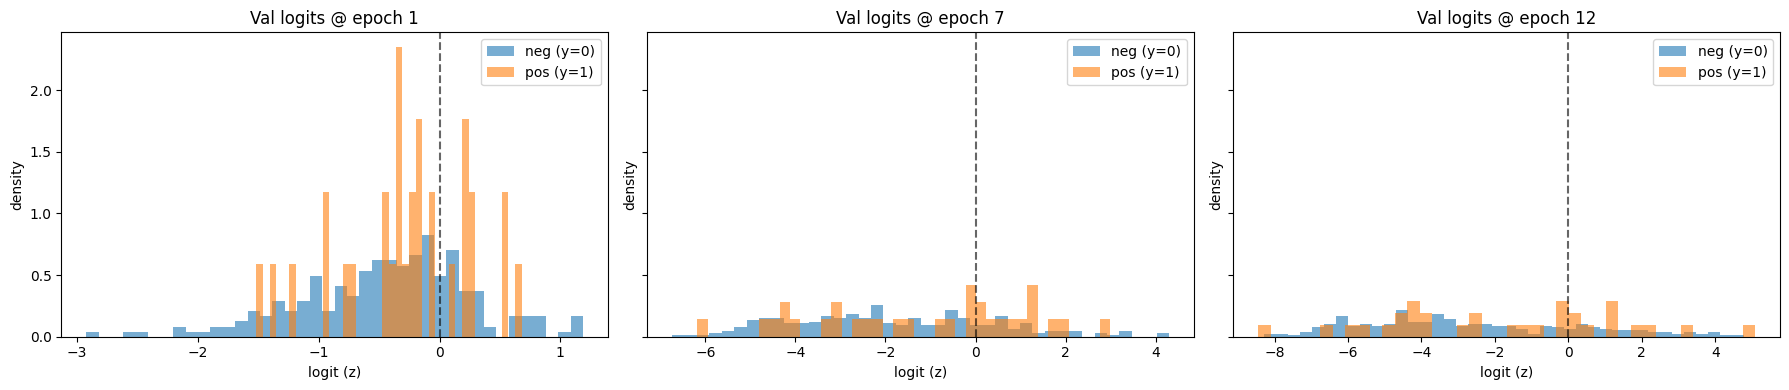

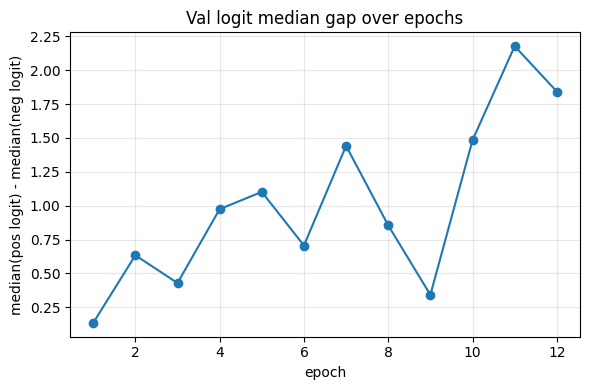

Train Loss,█▇▆▆▅▄▃▂▂▁▁▁
Val AUPR,▆▁▇▄▆▇▄▅▅▄▆█▆
Val AUROC,█▂▆▄▅▂▃▃▃▁▂▄▂
Val Loss,▅▂█▁▂▂▁▂▁▄▁▂▅
val_logit_gap,▁▃▂▄▄▃▅▃▂▆█▇
val_neg_median_logit,▇█▆▆▅▅▄▄▄▁▁▃
val_pos_median_logit,▆█▆▇▅▄▅▃▃▁▃▄
Train Loss,0.03647
Val AUPR,0.17921
Val AUROC,0.58406
Val Loss,0.7219


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 0.5946 | Val Loss 0.7924 | Val AUROC 0.5024 | Val AUPR 0.0807
EPOCH 2 - Train Loss 0.5286 | Val Loss 0.6604 | Val AUROC 0.5184 | Val AUPR 0.0793
EPOCH 3 - Train Loss 0.4862 | Val Loss 0.5585 | Val AUROC 0.5372 | Val AUPR 0.0789
EPOCH 4 - Train Loss 0.4069 | Val Loss 0.4879 | Val AUROC 0.5232 | Val AUPR 0.0784
EPOCH 5 - Train Loss 0.3115 | Val Loss 0.6259 | Val AUROC 0.5040 | Val AUPR 0.0863
EPOCH 6 - Train Loss 0.2248 | Val Loss 0.3918 | Val AUROC 0.4319 | Val AUPR 0.0656
EPOCH 7 - Train Loss 0.1764 | Val Loss 0.6260 | Val AUROC 0.4632 | Val AUPR 0.0896
EPOCH 8 - Train Loss 0.1161 | Val Loss 0.4132 | Val AUROC 0.4267 | Val AUPR 0.0694
EPOCH 9 - Train Loss 0.0685 | Val Loss 0.4410 | Val AUROC 0.4664 | Val AUPR 0.0684
EPOCH 10 - Train Loss 0.0538 | Val Loss 0.4219 | Val AUROC 0.4345 | Val AUPR 0.0704
EPOCH 11 - Train Loss 0.0370 | Val Loss 0.4923

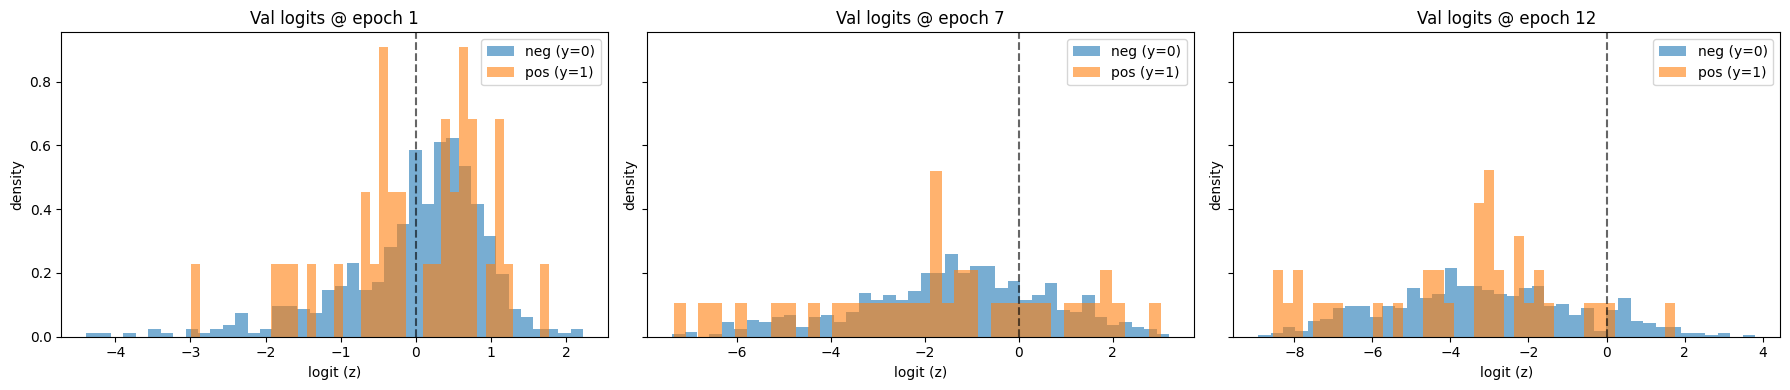

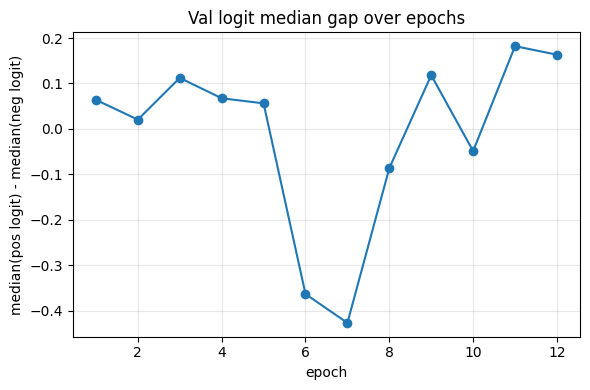

Train Loss,█▇▇▆▅▃▃▂▂▁▁▁
Val AUPR,█▃▃▃▃▄▁▄▂▂▂▁▁
Val AUROC,█▅▅▆▅▅▁▃▁▃▁▂▂
Val Loss,▄█▆▄▃▅▁▅▁▂▂▃▃
val_logit_gap,▇▆▇▇▇▂▁▅▇▅██
val_neg_median_logit,█▇▆▆▆▂▅▂▂▁▁▂
val_pos_median_logit,█▇▆▆▆▂▄▂▂▁▁▂
Train Loss,0.02655
Val AUPR,0.06346
Val AUROC,0.44916
Val Loss,0.49626


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 0.6111 | Val Loss 0.7716 | Val AUROC 0.5672 | Val AUPR 0.1469
EPOCH 2 - Train Loss 0.5402 | Val Loss 0.3892 | Val AUROC 0.5280 | Val AUPR 0.1797
EPOCH 3 - Train Loss 0.4767 | Val Loss 0.5306 | Val AUROC 0.5657 | Val AUPR 0.2081
EPOCH 4 - Train Loss 0.4215 | Val Loss 0.4360 | Val AUROC 0.5695 | Val AUPR 0.1413
EPOCH 5 - Train Loss 0.3567 | Val Loss 0.4199 | Val AUROC 0.5761 | Val AUPR 0.2316
EPOCH 6 - Train Loss 0.2730 | Val Loss 0.3841 | Val AUROC 0.5598 | Val AUPR 0.2231
EPOCH 7 - Train Loss 0.1767 | Val Loss 0.3905 | Val AUROC 0.5501 | Val AUPR 0.1427
EPOCH 8 - Train Loss 0.1551 | Val Loss 0.4403 | Val AUROC 0.5249 | Val AUPR 0.1617
EPOCH 9 - Train Loss 0.0966 | Val Loss 0.4371 | Val AUROC 0.5536 | Val AUPR 0.1526
EPOCH 10 - Train Loss 0.0530 | Val Loss 0.4329 | Val AUROC 0.5186 | Val AUPR 0.1449
EPOCH 11 - Train Loss 0.0585 | Val Loss 0.4973

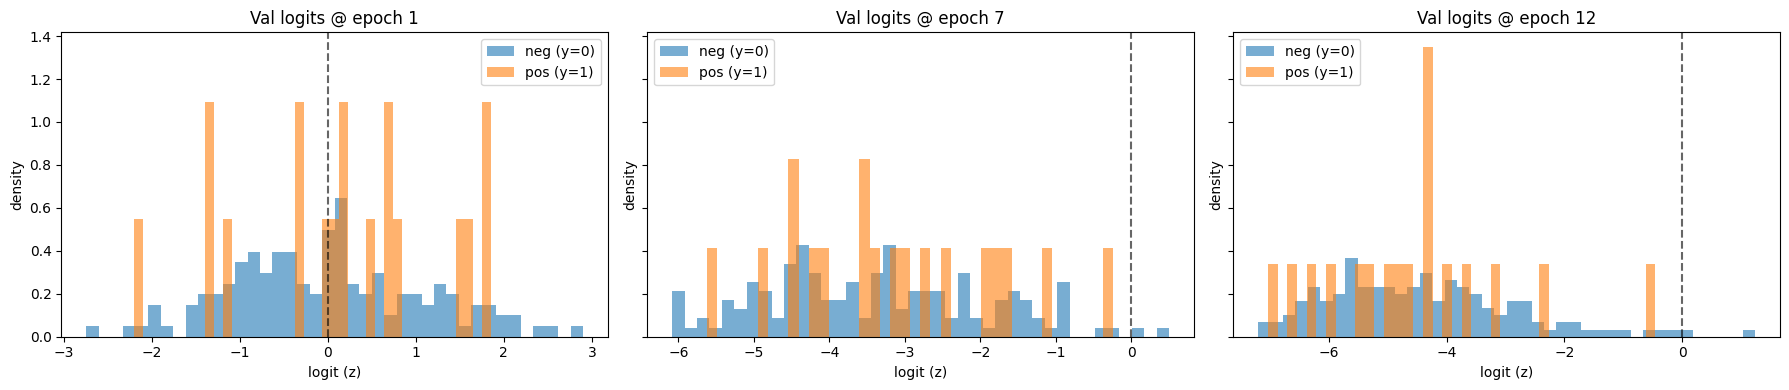

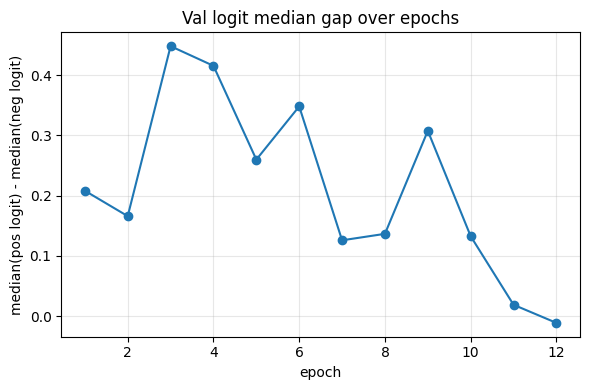

Train Loss,█▇▆▆▅▄▃▂▂▁▁▁
Val AUPR,▂▃▅▇▃█▇▃▄▃▃▂▁
Val AUROC,▃▇▅▇██▇▆▄▆▄▂▁
Val Loss,█▇▁▃▂▂▁▁▂▂▂▃▃
val_logit_gap,▄▄██▅▆▃▃▆▃▁▁
val_neg_median_logit,█▆▇▆▅▃▃▂▂▂▁▁
val_pos_median_logit,█▆▇▆▅▃▃▂▂▂▁▁
Train Loss,0.03426
Val AUPR,0.11561
Val AUROC,0.4763
Val Loss,0.50359


In [25]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        self.weights = weights  # optional per-sample weights (list/array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        if self.weights is None:
            return b, t, y
        else:
            w = torch.tensor(float(self.weights[idx]), dtype=torch.float32)
            return b, t, y, w

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=3000, replacement=True, generator = g)
    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="FT_on_meta_weighting_equal_sampling",
            name=f"split{i+1}_class_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

## target weighting (12 epochs)

Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 0.2970 | Val Loss 0.3713 | Val AUROC 0.6402 | Val AUPR 0.2726
EPOCH 2 - Train Loss 0.2131 | Val Loss 0.3598 | Val AUROC 0.6005 | Val AUPR 0.1675
EPOCH 3 - Train Loss 0.1661 | Val Loss 0.3613 | Val AUROC 0.6518 | Val AUPR 0.2445
EPOCH 4 - Train Loss 0.1438 | Val Loss 0.3690 | Val AUROC 0.6165 | Val AUPR 0.2189
EPOCH 5 - Train Loss 0.0854 | Val Loss 0.4502 | Val AUROC 0.5898 | Val AUPR 0.2492
EPOCH 6 - Train Loss 0.0974 | Val Loss 0.4302 | Val AUROC 0.6451 | Val AUPR 0.2254
EPOCH 7 - Train Loss 0.0538 | Val Loss 0.4519 | Val AUROC 0.6205 | Val AUPR 0.2502
EPOCH 8 - Train Loss 0.0321 | Val Loss 0.5214 | Val AUROC 0.5931 | Val AUPR 0.2375
EPOCH 9 - Train Loss 0.0321 | Val Loss 0.4380 | Val AUROC 0.6331 | Val AUPR 0.2436
EPOCH 10 - Train Loss 0.0202 | Val Loss 0.4971 | Val AUROC 0.6032 | Val AUPR 0.2222
EPOCH 11 - Train Loss 0.0127 | Val Loss 0.5804

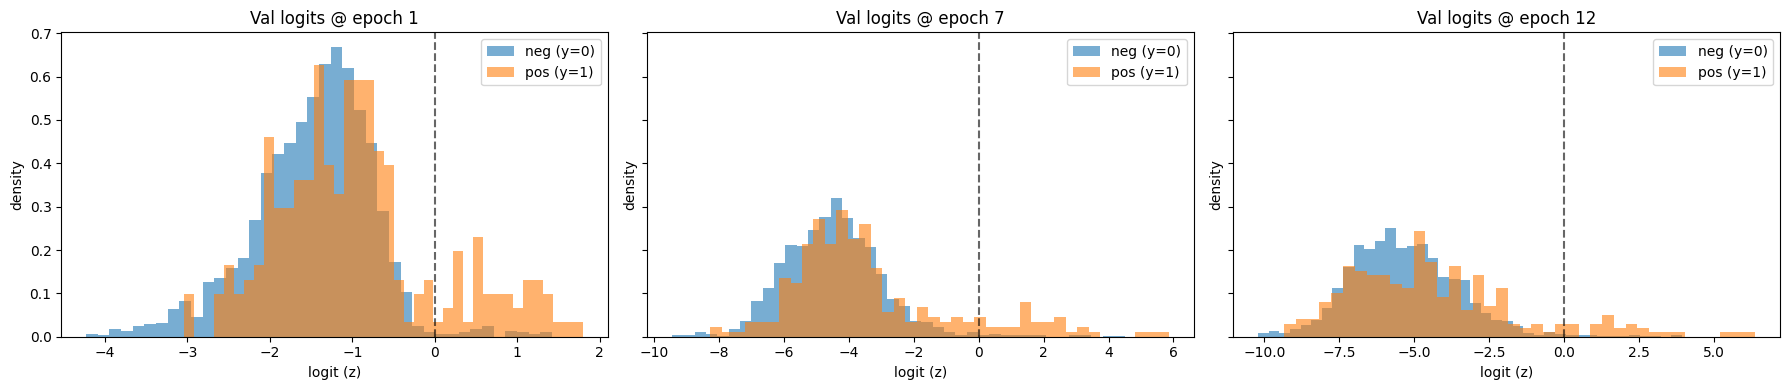

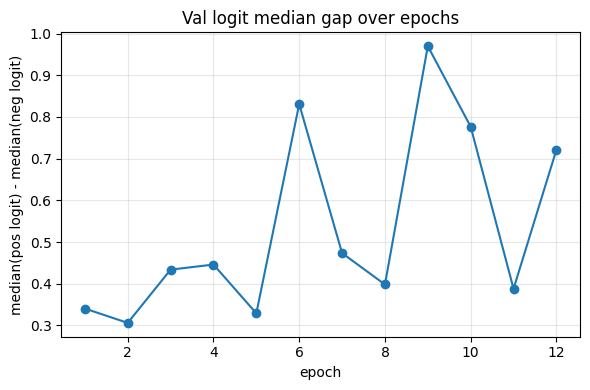

Train Loss,█▆▅▄▃▃▂▂▂▁▁▁
Val AUPR,▁█▃▇▅▇▆▇▆▇▆▆▆
Val AUROC,▁▇▄█▅▃█▆▄▇▄▂▃
Val Loss,█▁▁▁▁▂▂▂▂▂▂▃▃
val_logit_gap,▁▁▂▂▁▇▃▂█▆▂▅
val_neg_median_logit,█▆▅▅▃▃▃▂▃▂▁▁
val_pos_median_logit,█▆▅▅▃▄▃▂▄▃▁▂
Train Loss,0.0082
Val AUPR,0.22873
Val AUROC,0.58484
Val Loss,0.54665


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 0.3133 | Val Loss 0.5505 | Val AUROC 0.5592 | Val AUPR 0.1963
EPOCH 2 - Train Loss 0.2567 | Val Loss 0.7388 | Val AUROC 0.4395 | Val AUPR 0.1629
EPOCH 3 - Train Loss 0.1947 | Val Loss 0.6282 | Val AUROC 0.4851 | Val AUPR 0.1750
EPOCH 4 - Train Loss 0.1576 | Val Loss 0.6552 | Val AUROC 0.4908 | Val AUPR 0.1718
EPOCH 5 - Train Loss 0.1340 | Val Loss 0.7457 | Val AUROC 0.5187 | Val AUPR 0.1828
EPOCH 6 - Train Loss 0.1012 | Val Loss 0.7722 | Val AUROC 0.4781 | Val AUPR 0.1804
EPOCH 7 - Train Loss 0.0733 | Val Loss 0.8825 | Val AUROC 0.4300 | Val AUPR 0.1499
EPOCH 8 - Train Loss 0.0525 | Val Loss 0.8236 | Val AUROC 0.4336 | Val AUPR 0.1525
EPOCH 9 - Train Loss 0.0382 | Val Loss 0.9031 | Val AUROC 0.4331 | Val AUPR 0.1541
EPOCH 10 - Train Loss 0.0279 | Val Loss 0.9045 | Val AUROC 0.4754 | Val AUPR 0.1690
EPOCH 11 - Train Loss 0.0254 | Val Loss 1.0218

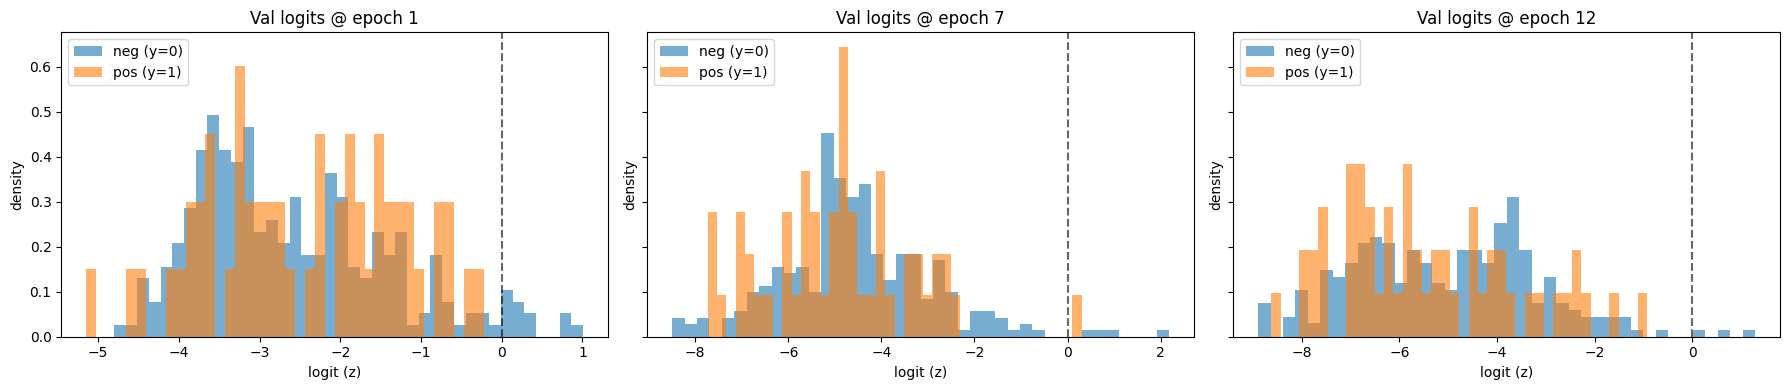

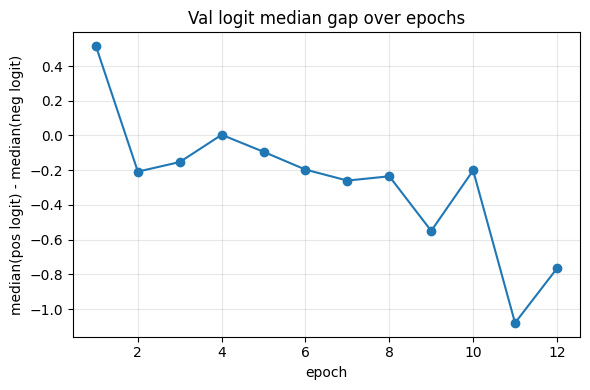

Train Loss,█▇▅▄▄▃▂▂▁▁▁▁
Val AUPR,█▅▃▃▃▄▄▂▂▂▃▁▂
Val AUROC,█▇▃▄▅▅▄▃▃▃▄▁▃
Val Loss,█▁▃▂▂▃▄▅▄▅▅▇▆
val_logit_gap,█▅▅▆▅▅▅▅▃▅▁▂
val_neg_median_logit,█▅▇▇▄▄▃▃▂▁▁▂
val_pos_median_logit,█▅▆▆▄▄▄▄▃▃▁▂
Train Loss,0.03436
Val AUPR,0.15585
Val AUROC,0.43333
Val Loss,0.95505


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 0.3146 | Val Loss 0.3622 | Val AUROC 0.6482 | Val AUPR 0.1986
EPOCH 2 - Train Loss 0.2279 | Val Loss 0.4483 | Val AUROC 0.6137 | Val AUPR 0.1509
EPOCH 3 - Train Loss 0.2081 | Val Loss 0.4362 | Val AUROC 0.5819 | Val AUPR 0.1362
EPOCH 4 - Train Loss 0.1706 | Val Loss 0.5101 | Val AUROC 0.5865 | Val AUPR 0.1361
EPOCH 5 - Train Loss 0.1578 | Val Loss 0.4859 | Val AUROC 0.6367 | Val AUPR 0.1816
EPOCH 6 - Train Loss 0.1192 | Val Loss 0.4262 | Val AUROC 0.6222 | Val AUPR 0.1619
EPOCH 7 - Train Loss 0.0867 | Val Loss 0.4535 | Val AUROC 0.5902 | Val AUPR 0.1359
EPOCH 8 - Train Loss 0.0800 | Val Loss 0.5764 | Val AUROC 0.5381 | Val AUPR 0.1259
EPOCH 9 - Train Loss 0.0494 | Val Loss 0.5047 | Val AUROC 0.5416 | Val AUPR 0.1295
EPOCH 10 - Train Loss 0.0488 | Val Loss 0.4865 | Val AUROC 0.6055 | Val AUPR 0.1498
EPOCH 11 - Train Loss 0.0460 | Val Loss 0.6868

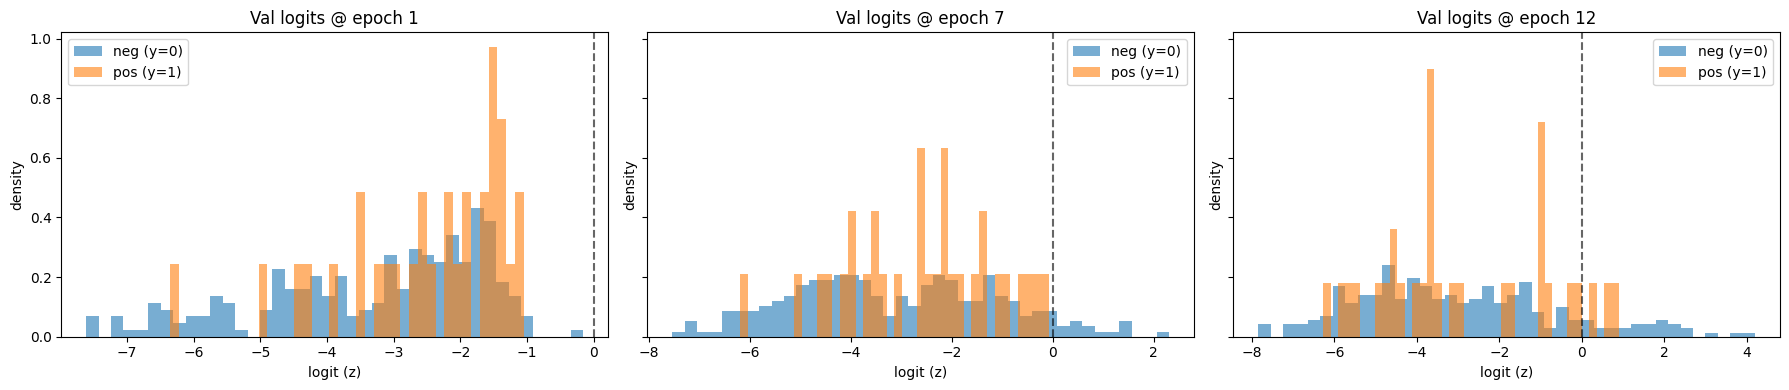

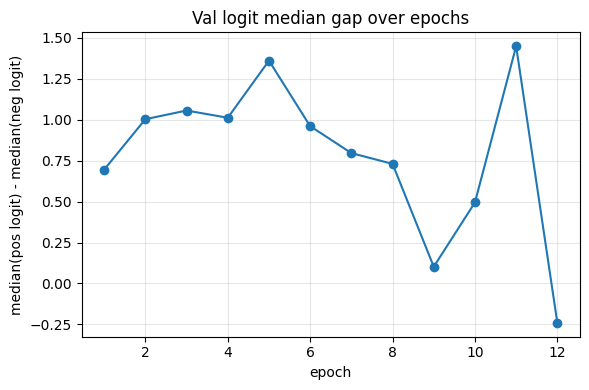

Train Loss,█▆▅▄▄▃▂▂▁▁▁▁
Val AUPR,▆█▃▂▂▆▄▂▁▁▃▂▁
Val AUROC,█▇▅▃▃▆▅▄▁▁▄▄▁
Val Loss,█▁▃▂▄▃▂▃▅▄▃▇▆
val_logit_gap,▅▆▆▆█▆▅▅▂▄█▁
val_neg_median_logit,▄█▆█▇▂▃▆▁▂▃▃
val_pos_median_logit,▅█▇██▄▄▆▁▃▆▁
Train Loss,0.03791
Val AUPR,0.1269
Val AUROC,0.53581
Val Loss,0.60829


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 0.3427 | Val Loss 0.3576 | Val AUROC 0.5994 | Val AUPR 0.0886
EPOCH 2 - Train Loss 0.2499 | Val Loss 0.4598 | Val AUROC 0.6630 | Val AUPR 0.0984
EPOCH 3 - Train Loss 0.1978 | Val Loss 0.2828 | Val AUROC 0.5760 | Val AUPR 0.0970
EPOCH 4 - Train Loss 0.1748 | Val Loss 0.3267 | Val AUROC 0.6370 | Val AUPR 0.0974
EPOCH 5 - Train Loss 0.1394 | Val Loss 0.2923 | Val AUROC 0.6034 | Val AUPR 0.1264
EPOCH 6 - Train Loss 0.1045 | Val Loss 0.3685 | Val AUROC 0.5438 | Val AUPR 0.0896
EPOCH 7 - Train Loss 0.0739 | Val Loss 0.3369 | Val AUROC 0.6043 | Val AUPR 0.0921
EPOCH 8 - Train Loss 0.0646 | Val Loss 0.3236 | Val AUROC 0.5723 | Val AUPR 0.0853
EPOCH 9 - Train Loss 0.0447 | Val Loss 0.3747 | Val AUROC 0.6138 | Val AUPR 0.1082
EPOCH 10 - Train Loss 0.0379 | Val Loss 0.3700 | Val AUROC 0.5630 | Val AUPR 0.0895
EPOCH 11 - Train Loss 0.0452 | Val Loss 0.3583

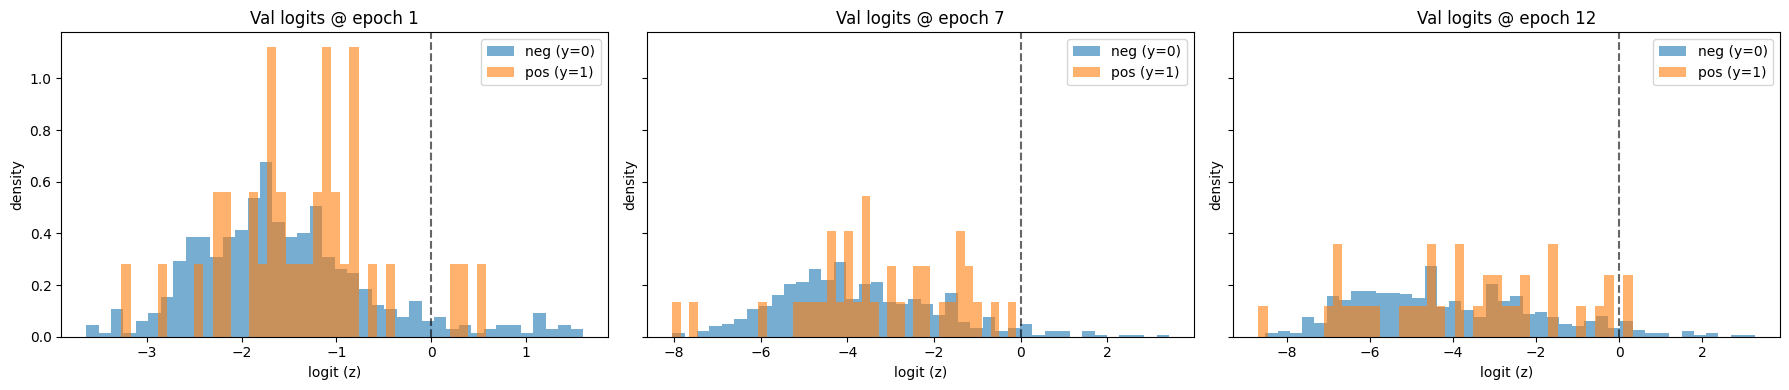

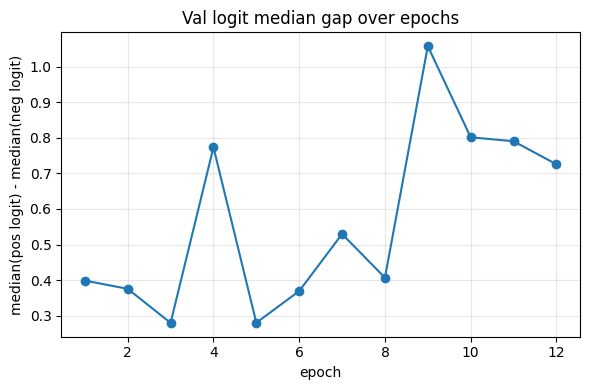

Train Loss,█▆▅▄▃▃▂▂▁▁▁▁
Val AUPR,█▂▃▃▃█▂▂▁▅▂▂▁
Val AUROC,▃▄█▃▆▄▁▅▃▅▂▃▂
Val Loss,█▃▅▁▂▁▃▂▂▃▃▃▃
val_logit_gap,▂▂▁▅▁▂▃▂█▆▆▅
val_neg_median_logit,▇█▃▅▂▂▂▂▃▁▂▁
val_pos_median_logit,▇█▂▆▁▂▂▂▃▁▂▁
Train Loss,0.02784
Val AUPR,0.08673
Val AUROC,0.55711
Val Loss,0.37984


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 0.3043 | Val Loss 0.4210 | Val AUROC 0.4328 | Val AUPR 0.1090
EPOCH 2 - Train Loss 0.2190 | Val Loss 0.3715 | Val AUROC 0.5614 | Val AUPR 0.1885
EPOCH 3 - Train Loss 0.1851 | Val Loss 0.4147 | Val AUROC 0.5451 | Val AUPR 0.1739
EPOCH 4 - Train Loss 0.1865 | Val Loss 0.4068 | Val AUROC 0.5097 | Val AUPR 0.1287
EPOCH 5 - Train Loss 0.1336 | Val Loss 0.3995 | Val AUROC 0.5303 | Val AUPR 0.1872
EPOCH 6 - Train Loss 0.1502 | Val Loss 0.3996 | Val AUROC 0.5451 | Val AUPR 0.1988
EPOCH 7 - Train Loss 0.1043 | Val Loss 0.4458 | Val AUROC 0.5097 | Val AUPR 0.1714
EPOCH 8 - Train Loss 0.0825 | Val Loss 0.4233 | Val AUROC 0.5633 | Val AUPR 0.2231
EPOCH 9 - Train Loss 0.0597 | Val Loss 0.5806 | Val AUROC 0.5241 | Val AUPR 0.1720
EPOCH 10 - Train Loss 0.0420 | Val Loss 0.4548 | Val AUROC 0.5486 | Val AUPR 0.1816
EPOCH 11 - Train Loss 0.0464 | Val Loss 0.5498

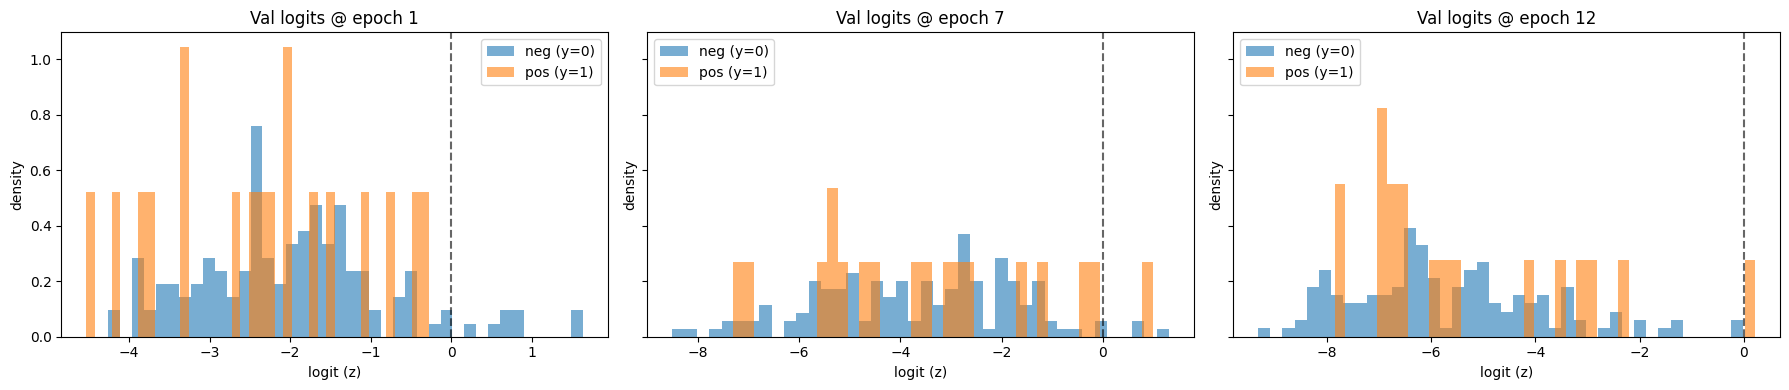

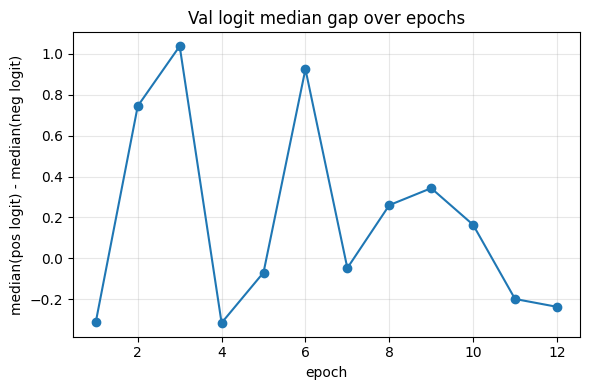

Train Loss,█▆▅▅▄▄▃▂▂▁▁▁
Val AUPR,▂▁▆▅▂▆▇▅█▅▅▂▆
Val AUROC,▅▁█▇▅▆▇▅█▆▇▄▆
Val Loss,█▂▁▂▂▁▁▂▂▄▂▄▄
val_logit_gap,▁▆█▁▂▇▂▄▄▃▂▁
val_neg_median_logit,██▇▆▆▆▆▄▁▄▂▁
val_pos_median_logit,▇██▅▅▆▅▄▂▄▂▁
Train Loss,0.03196
Val AUPR,0.19014
Val AUROC,0.51826
Val Loss,0.55953


In [26]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        self.weights = weights  # optional per-sample weights (list/array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        if self.weights is None:
            return b, t, y
        else:
            w = torch.tensor(float(self.weights[idx]), dtype=torch.float32)
            return b, t, y, w

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=3000, replacement=True, generator = g)
    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="FT_on_meta_weighting_equal_sampling",
            name=f"split{i+1}_target_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

## target+class weighting (12 epochs)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 0.4267 | Val Loss 0.4743 | Val AUROC 0.6313 | Val AUPR 0.1784
EPOCH 2 - Train Loss 0.2797 | Val Loss 0.3851 | Val AUROC 0.5814 | Val AUPR 0.1989
EPOCH 3 - Train Loss 0.1821 | Val Loss 0.3952 | Val AUROC 0.6281 | Val AUPR 0.1982
EPOCH 4 - Train Loss 0.1104 | Val Loss 0.4310 | Val AUROC 0.5636 | Val AUPR 0.2035
EPOCH 5 - Train Loss 0.0484 | Val Loss 0.4499 | Val AUROC 0.5560 | Val AUPR 0.2057
EPOCH 6 - Train Loss 0.0343 | Val Loss 0.4341 | Val AUROC 0.5746 | Val AUPR 0.2226
EPOCH 7 - Train Loss 0.0137 | Val Loss 0.4867 | Val AUROC 0.5473 | Val AUPR 0.2044
EPOCH 8 - Train Loss 0.0070 | Val Loss 0.4804 | Val AUROC 0.5408 | Val AUPR 0.1781
EPOCH 9 - Train Loss 0.0039 | Val Loss 0.5169 | Val AUROC 0.5505 | Val AUPR 0.1951
EPOCH 10 - Train Loss 0.0033 | Val Loss 0.5303 | Val AUROC 0.5420 | Val AUPR 0.1891
EPOCH 11 - Train Loss 0.0020 | Val Loss 0.5468

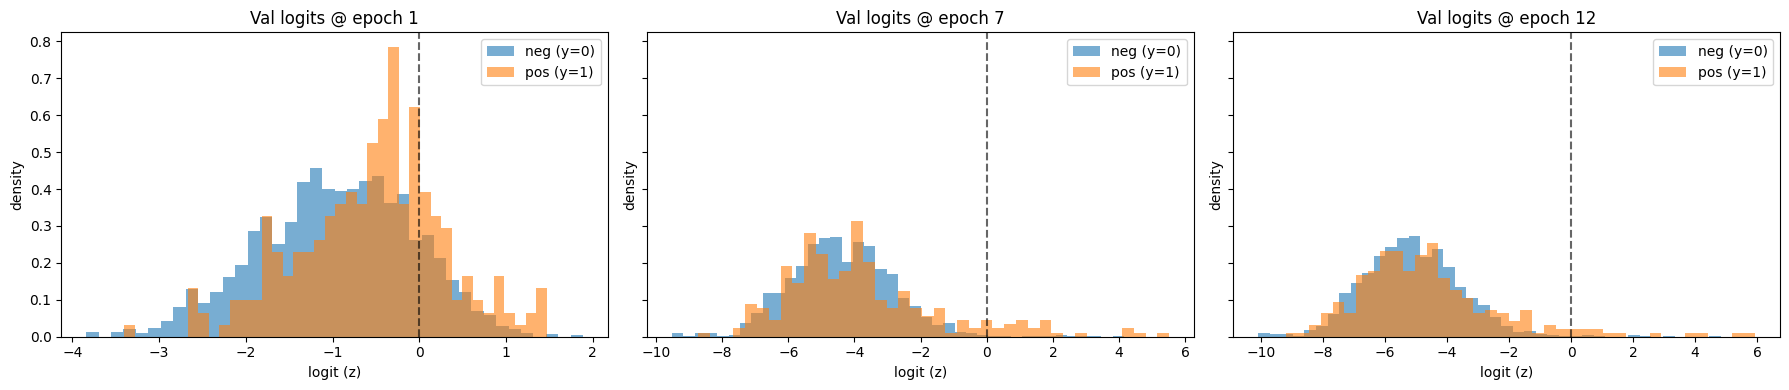

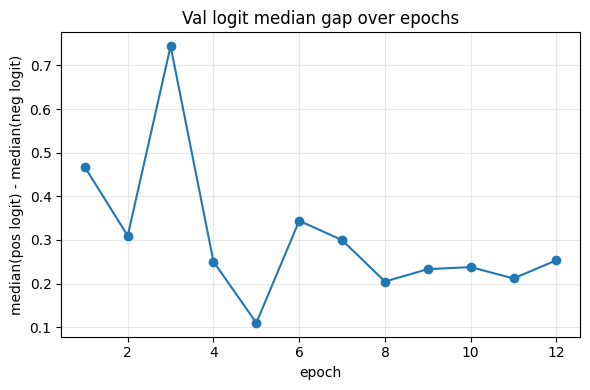

Train Loss,█▆▄▃▂▂▁▁▁▁▁▁
Val AUPR,▁▅▆▆▇▇█▇▅▆▆▆▆
Val AUROC,▂█▄█▃▂▄▂▁▂▁▁▁
Val Loss,█▂▁▁▁▂▁▂▂▂▂▂▂
val_logit_gap,▅▃█▃▁▄▃▂▂▂▂▃
val_neg_median_logit,█▆▅▃▃▃▂▃▂▁▁▁
val_pos_median_logit,█▆▆▃▂▃▂▂▂▁▁▁
Train Loss,0.00178
Val AUPR,0.18883
Val AUROC,0.54632
Val Loss,0.55231


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 0.5434 | Val Loss 0.5478 | Val AUROC 0.5440 | Val AUPR 0.1933
EPOCH 2 - Train Loss 0.4512 | Val Loss 0.6130 | Val AUROC 0.5312 | Val AUPR 0.1882
EPOCH 3 - Train Loss 0.3857 | Val Loss 0.5539 | Val AUROC 0.5780 | Val AUPR 0.1998
EPOCH 4 - Train Loss 0.3433 | Val Loss 0.5744 | Val AUROC 0.5756 | Val AUPR 0.2204
EPOCH 5 - Train Loss 0.2803 | Val Loss 0.6031 | Val AUROC 0.6138 | Val AUPR 0.2263
EPOCH 6 - Train Loss 0.2383 | Val Loss 0.6592 | Val AUROC 0.5676 | Val AUPR 0.2114
EPOCH 7 - Train Loss 0.1889 | Val Loss 0.6706 | Val AUROC 0.5492 | Val AUPR 0.2046
EPOCH 8 - Train Loss 0.1276 | Val Loss 0.6959 | Val AUROC 0.5891 | Val AUPR 0.2043
EPOCH 9 - Train Loss 0.1154 | Val Loss 0.7593 | Val AUROC 0.5099 | Val AUPR 0.1892
EPOCH 10 - Train Loss 0.0736 | Val Loss 0.8204 | Val AUROC 0.5156 | Val AUPR 0.1920
EPOCH 11 - Train Loss 0.0496 | Val Loss 0.8111

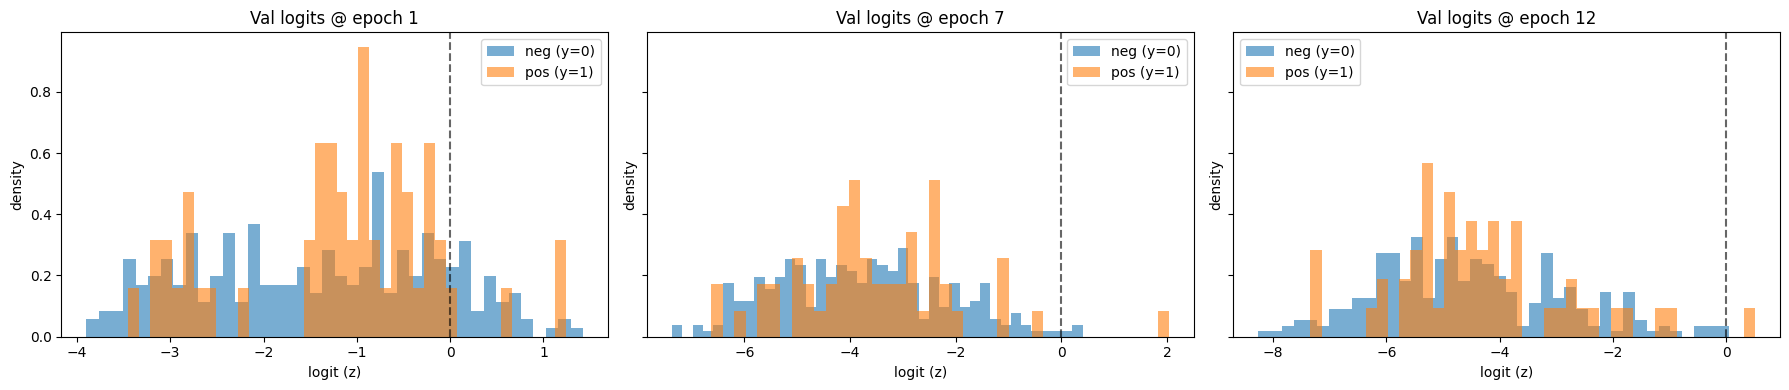

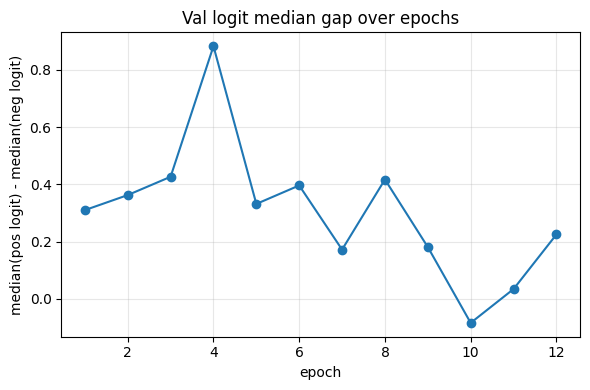

Train Loss,█▇▆▅▄▄▃▂▂▁▁▁
Val AUPR,█▂▁▃▆▆▄▃▃▁▂▁▂
Val AUROC,▇▃▂▆▅█▅▄▆▁▁▁▃
Val Loss,█▁▂▁▁▂▂▃▃▄▄▄▄
val_logit_gap,▄▄▅█▄▄▃▅▃▁▂▃
val_neg_median_logit,█▄▅▄▃▃▃▂▂▁▁▁
val_pos_median_logit,█▅▅▆▄▄▃▃▂▁▁▂
Train Loss,0.04819
Val AUPR,0.19634
Val AUROC,0.53571
Val Loss,0.78382


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 0.5325 | Val Loss 0.5038 | Val AUROC 0.6200 | Val AUPR 0.1670
EPOCH 2 - Train Loss 0.4385 | Val Loss 0.5607 | Val AUROC 0.6352 | Val AUPR 0.1683
EPOCH 3 - Train Loss 0.3937 | Val Loss 0.6638 | Val AUROC 0.6305 | Val AUPR 0.1672
EPOCH 4 - Train Loss 0.3261 | Val Loss 0.5398 | Val AUROC 0.6206 | Val AUPR 0.1623
EPOCH 5 - Train Loss 0.2912 | Val Loss 0.5825 | Val AUROC 0.6490 | Val AUPR 0.1762
EPOCH 6 - Train Loss 0.2580 | Val Loss 0.6962 | Val AUROC 0.6126 | Val AUPR 0.1568
EPOCH 7 - Train Loss 0.2114 | Val Loss 0.5335 | Val AUROC 0.6110 | Val AUPR 0.1585
EPOCH 8 - Train Loss 0.1741 | Val Loss 0.6218 | Val AUROC 0.5988 | Val AUPR 0.1573
EPOCH 9 - Train Loss 0.1283 | Val Loss 0.6248 | Val AUROC 0.6152 | Val AUPR 0.1900
EPOCH 10 - Train Loss 0.0930 | Val Loss 0.7275 | Val AUROC 0.6171 | Val AUPR 0.1688
EPOCH 11 - Train Loss 0.0918 | Val Loss 0.5024

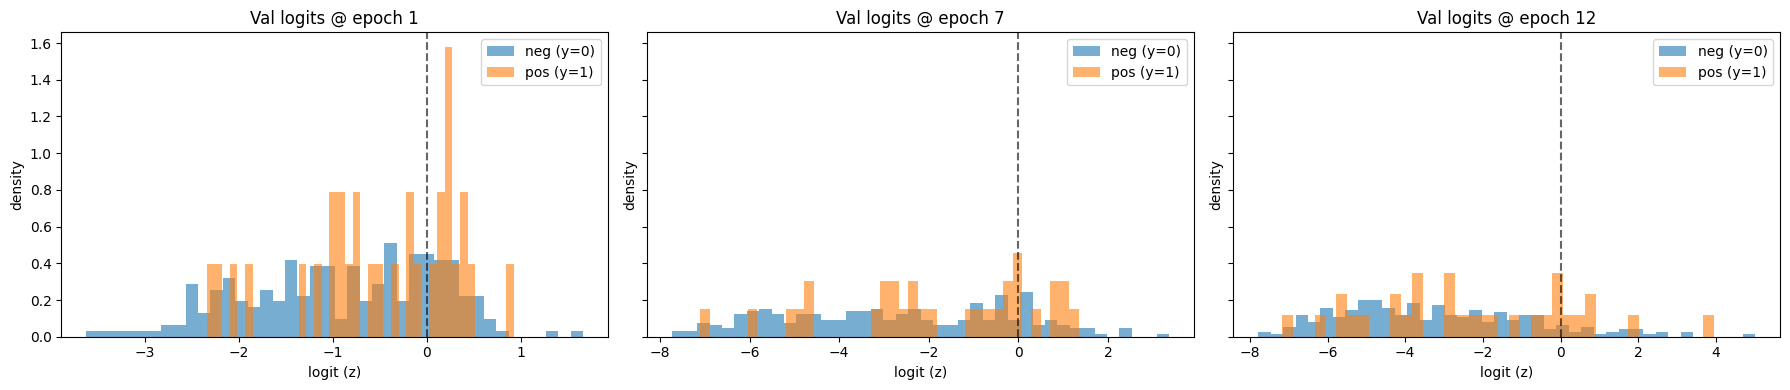

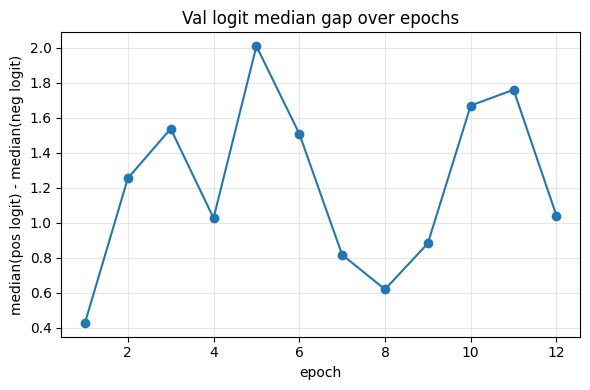

Train Loss,█▇▆▅▅▄▃▃▂▂▂▁
Val AUPR,▆▃▃▃▂▅▁▁▁█▄▇▆
Val AUROC,█▃▄▄▃▅▂▂▁▂▃▃▂
Val Loss,█▁▃▆▂▃▇▂▅▅█▁▂
val_logit_gap,▁▅▆▄█▆▃▂▃▆▇▄
val_neg_median_logit,█▇▇▆▅▆▃▄▄▅▁▁
val_pos_median_logit,▆▇█▅█▇▂▃▄▆▂▁
Train Loss,0.04658
Val AUPR,0.18006
Val AUROC,0.61017
Val Loss,0.52939


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 0.5564 | Val Loss 0.4811 | Val AUROC 0.5335 | Val AUPR 0.1015
EPOCH 2 - Train Loss 0.4356 | Val Loss 0.4127 | Val AUROC 0.5266 | Val AUPR 0.0821
EPOCH 3 - Train Loss 0.3659 | Val Loss 0.4111 | Val AUROC 0.5037 | Val AUPR 0.0849
EPOCH 4 - Train Loss 0.3257 | Val Loss 0.4017 | Val AUROC 0.5134 | Val AUPR 0.0777
EPOCH 5 - Train Loss 0.2974 | Val Loss 0.5234 | Val AUROC 0.4831 | Val AUPR 0.0855
EPOCH 6 - Train Loss 0.2464 | Val Loss 0.4156 | Val AUROC 0.4983 | Val AUPR 0.0793
EPOCH 7 - Train Loss 0.1957 | Val Loss 0.4175 | Val AUROC 0.4666 | Val AUPR 0.0828
EPOCH 8 - Train Loss 0.1660 | Val Loss 0.5324 | Val AUROC 0.5099 | Val AUPR 0.0873
EPOCH 9 - Train Loss 0.0976 | Val Loss 0.4125 | Val AUROC 0.4752 | Val AUPR 0.0768
EPOCH 10 - Train Loss 0.0846 | Val Loss 0.5931 | Val AUROC 0.4491 | Val AUPR 0.0664
EPOCH 11 - Train Loss 0.0782 | Val Loss 0.4413

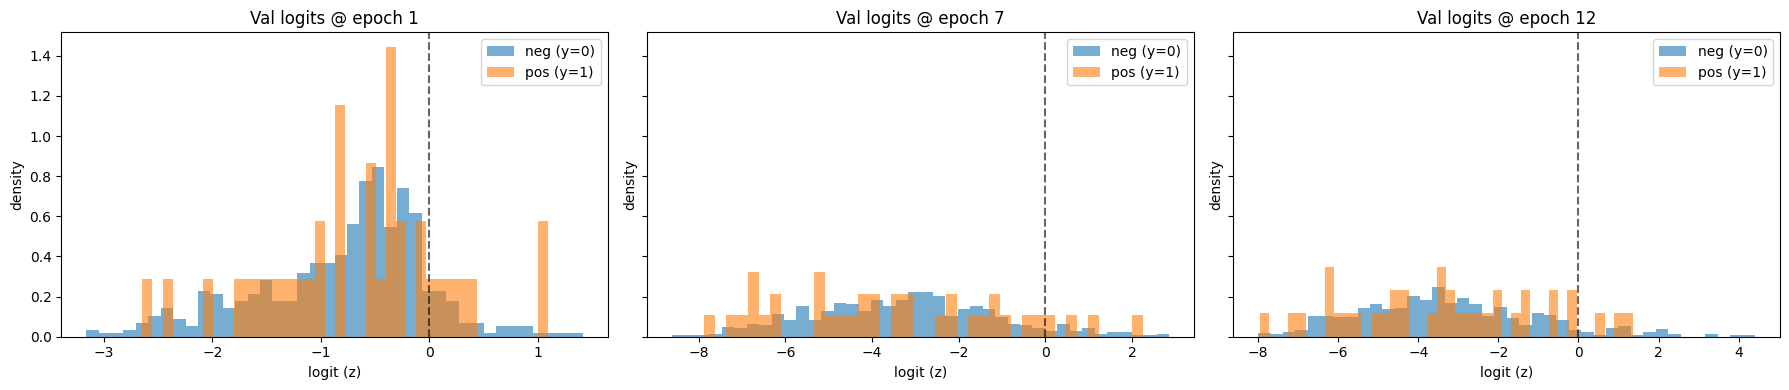

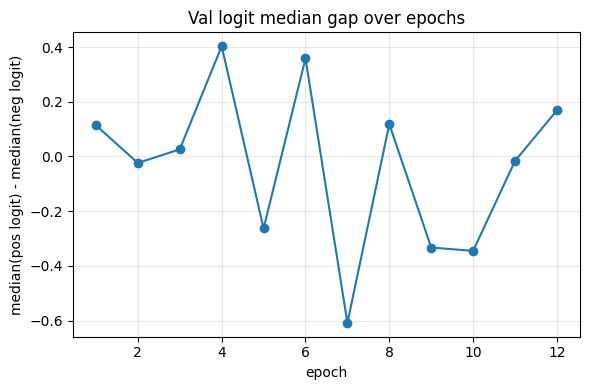

Train Loss,█▆▅▅▄▄▃▃▂▁▁▁
Val AUPR,█▅▃▃▂▃▃▃▄▂▁▂▂
Val AUROC,█▆▅▄▄▃▄▂▄▂▁▄▄
Val Loss,▇▄▁▁▁▅▂▂▆▁█▂▂
val_logit_gap,▆▅▅█▃█▁▆▃▃▅▆
val_neg_median_logit,█▆▆▅▆▃▂▄▁▄▂▂
val_pos_median_logit,█▆▆▆▅▄▁▄▁▃▂▂
Train Loss,0.05063
Val AUPR,0.07622
Val AUROC,0.50136
Val Loss,0.43941


Training model 989589a8-9fbd-4ae8-b193-7777d4956908
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 0.5406 | Val Loss 0.5578 | Val AUROC 0.5194 | Val AUPR 0.1683
EPOCH 2 - Train Loss 0.4214 | Val Loss 0.4224 | Val AUROC 0.4701 | Val AUPR 0.1107
EPOCH 3 - Train Loss 0.3852 | Val Loss 0.4574 | Val AUROC 0.5552 | Val AUPR 0.1810
EPOCH 4 - Train Loss 0.3341 | Val Loss 0.3880 | Val AUROC 0.5602 | Val AUPR 0.1637
EPOCH 5 - Train Loss 0.2805 | Val Loss 0.3848 | Val AUROC 0.5361 | Val AUPR 0.1301
EPOCH 6 - Train Loss 0.2491 | Val Loss 0.4183 | Val AUROC 0.5303 | Val AUPR 0.1509
EPOCH 7 - Train Loss 0.2194 | Val Loss 0.4197 | Val AUROC 0.5357 | Val AUPR 0.1732
EPOCH 8 - Train Loss 0.1820 | Val Loss 0.4451 | Val AUROC 0.5769 | Val AUPR 0.1590
EPOCH 9 - Train Loss 0.1218 | Val Loss 0.4604 | Val AUROC 0.5183 | Val AUPR 0.1240
EPOCH 10 - Train Loss 0.1147 | Val Loss 0.4833 | Val AUROC 0.5392 | Val AUPR 0.1397
EPOCH 11 - Train Loss 0.0730 | Val Loss 0.5310

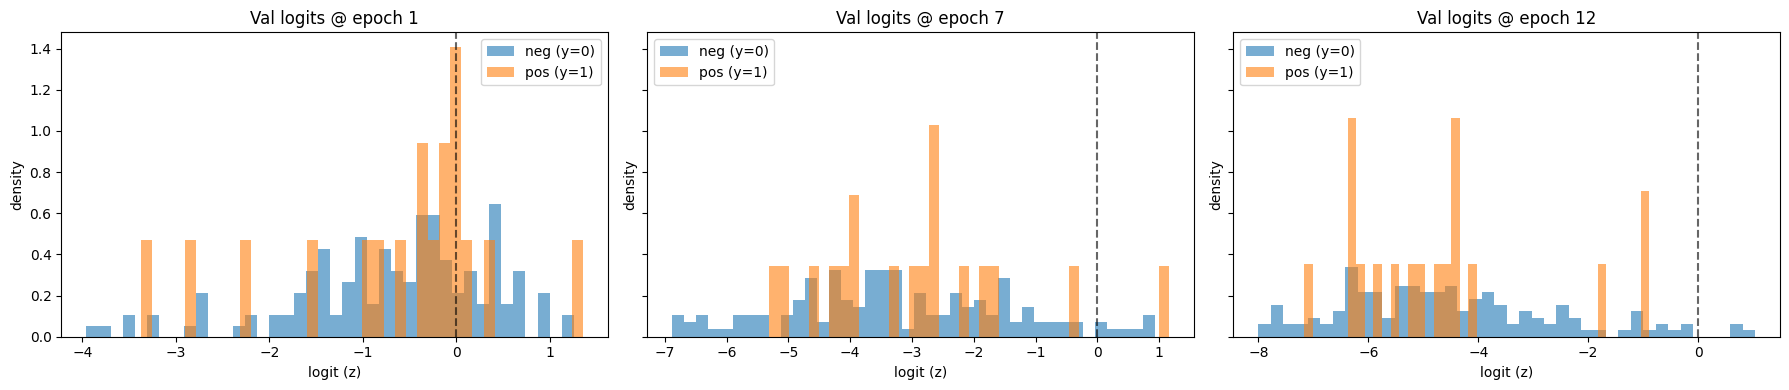

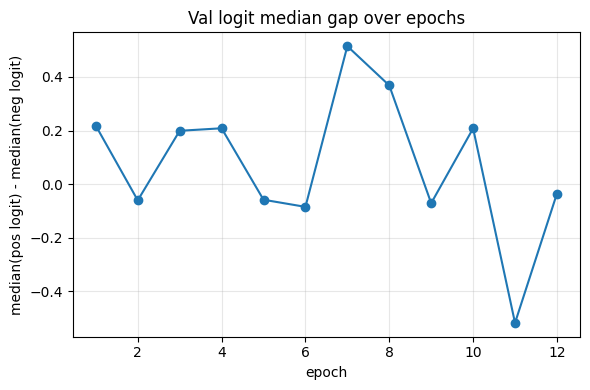

Train Loss,█▆▆▅▄▄▃▃▂▂▁▁
Val AUPR,▃▇▁█▆▃▅▇▆▃▄▁▂
Val AUROC,▄▅▂▇▇▆▆▆█▅▆▁▃
Val Loss,█▄▂▂▁▁▂▂▂▂▃▃▃
val_logit_gap,▆▄▆▆▄▄█▇▄▆▁▄
val_neg_median_logit,█▆▇▅▄▄▃▂▂▁▁▁
val_pos_median_logit,█▆▇▆▄▄▅▃▃▂▁▂
Train Loss,0.0607
Val AUPR,0.11643
Val AUROC,0.47824
Val Loss,0.52778


In [28]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples, weights=None):
        self.examples = examples
        self.weights = weights  # optional per-sample weights (list/array)

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        if self.weights is None:
            return b, t, y
        else:
            w = torch.tensor(float(self.weights[idx]), dtype=torch.float32)
            return b, t, y, w

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    # NEW model per split
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    # validation
    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_binders = [ALL_btl[idx] for idx in val_idx]
    val_binders = PairListDataset(val_binders)

    # training
    train_targets = cv_splits[i][1]

    train_weights_class = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "class_weight"].tolist()
    train_weights_target = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "target_weight"].tolist()
    train_weights_combined = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight"].tolist()
    train_weights_combined_boost_positives = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets), "combined_weight_boost_pos"].tolist()

    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_binders = [ALL_btl[idx] for idx in train_idx]
    train_binders = PairListDataset(train_binders)

    # loaders
    ### no weighting
    # train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)

    ### class weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_class, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### target weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_target, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True)
    # train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)

    ### combined weighting (boost positives)
    # train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=train_binders.__len__(), replacement=True, generator = g)
    train_sampler = WeightedRandomSampler(weights=train_weights_combined, num_samples=3000, replacement=True, generator = g)

    train_loader   = DataLoader(train_binders,   batch_size=20, sampler=train_sampler)
    
    val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

    # accelerator
    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # wandb
    if use_wandb:
        run = wandb.init(
            project="FT_on_meta_weighting_equal_sampling",
            name=f"split{i+1}_class&target_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    # train
    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_binders,   # ok if you truly want “full val”
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1
    )
    training_wrapper.train_model()

    # cleanup between splits
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

## pos_weight in binary loss calculation

In [24]:
def batch(iterable, n=20):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

all_hist = []

class TrainWrapper_MetaAnal():

    def __init__(self, model, training_loader, validation_loader, test_dataset, 
                 optimizer, EPOCHS, runID, pos_weight, device, test_indexes_for_auROC=None,
                 auROC_batch_size=18, model_save_steps=False, model_save_path=False, 
                 v=False, wandb_tracker=False, split_id=None):
        
        self.model = model 
        self.training_loader = training_loader
        self.validation_loader = validation_loader
        self.EPOCHS = EPOCHS
        self.wandb_tracker = wandb_tracker
        self.model_save_steps = model_save_steps
        self.verbose = v
        self.split_id = split_id
        self.best_vloss = 1e09
        self.optimizer = optimizer
        self.pos_weight = pos_weight
        self.runID = runID
        self.trained_model_dir = model_save_path
        self.print_frequency_loss = 1
        self.device = device
        self.test_indexes_for_auROC = test_indexes_for_auROC
        self.auROC_batch_size = auROC_batch_size
        self.test_dataset = test_dataset

    def train_one_epoch(self):
        self.model.train()
        running_loss = 0.0
        # for batch_data in tqdm(self.training_loader, total=len(self.training_loader), desc="Running through epoch"):
        for batch_data in self.training_loader:
            if batch_data[0].size(0) == 1:
                continue
            self.optimizer.zero_grad()
            loss = self.model.training_step(batch_data, self.pos_weight, self.device)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item()

        return running_loss / max(1, len(self.training_loader))

    def calc_auroc_aupr_on_indexes(self, model, validation_dataset, batch_size=20, pad_value=-5000.0):
        
        model.eval()
        all_scores, all_labels = [], []
        batched_data = batch(validation_dataset, n=batch_size)
        
        with torch.no_grad():
            # for one_batch in tqdm(batched_data, total= len(validation_dataset)/batch_size, desc="Calculating AUC"):
            for one_batch in batched_data:
                
                embedding_pep, embedding_prot, binder_labels = batch
                embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()
                
                logits = model.forward(binders, targets)
                
                all_scores.extend(logits.tolist())
                all_labels.extend(binder_labels.tolist())
                
        all_scores = np.array(all_scores, dtype=np.float64)
        all_labels = np.array(all_labels, dtype=np.int64)
        
        fpr, tpr, _ = metrics.roc_curve(all_labels, all_scores)
        auroc = metrics.roc_auc_score(all_labels, all_scores)
        aupr  = metrics.average_precision_score(all_labels, all_scores)
        
        return auroc, aupr, fpr, tpr

    def validate(self, dataloader, indexes_for_auc=False, auROC_dataset=False):
        
        self.model.eval()
        running_loss, n_loss = 0.0, 0
        all_scores, all_labels = [], []
        
        with torch.no_grad():
            # for batch_data in tqdm(dataloader, total=len(dataloader), desc="Validation"):
            for batch_data in dataloader:
                
                loss, logits, labels = self.model.validation_step(batch_data, self.device)
                
                running_loss += float(loss)
                n_loss += 1
                all_scores.append(logits.detach().float().cpu())
                all_labels.append(labels.detach().long().cpu())
    
        val_loss = running_loss / max(1, n_loss)
    
        if all_scores:
            scores = torch.cat(all_scores).numpy()
            labs   = torch.cat(all_labels).numpy()
            val_auroc = metrics.roc_auc_score(labs, scores)
            val_aupr  = metrics.average_precision_score(labs, scores)
        else:
            scores = np.array([], dtype=np.float64)   # <-- define when empty
            labs   = np.array([], dtype=np.int64)
            val_auroc = float("nan")
            val_aupr  = float("nan")
    
        return val_loss, val_auroc, val_aupr, scores, labs

    def _plot_val_histories(self, hist, epochs_to_show=("first","middle","last")):
    
        if not hist:
            return
    
        epochs = [e for (e,_,_) in hist]
        choose = []
        if "first" in epochs_to_show:
            choose.append(epochs[0])
        if "middle" in epochs_to_show:
            choose.append(epochs[len(epochs)//2])
        if "last" in epochs_to_show:
            choose.append(epochs[-1])
        choose = sorted(set(choose))
    
        # grid of histograms
        ncols = len(choose)
        fig, axs = plt.subplots(1, ncols, figsize=(6*ncols, 4), sharey=True)
        if ncols == 1: axs = [axs]
    
        for ax, ek in zip(axs, choose):
            # fetch data for epoch ek
            for (e, s, y) in hist:
                if e == ek:
                    scores, labs = s, y
                    break
            pos = scores[labs == 1]
            neg = scores[labs == 0]
    
            ax.hist(neg, bins=40, density=True, alpha=0.6, label="neg (y=0)")
            ax.hist(pos, bins=40, density=True, alpha=0.6, label="pos (y=1)")
            ax.axvline(0.0, ls="--", color="k", alpha=0.6)  # decision boundary (logit 0)
            ax.set_title(f"Val logits @ epoch {ek}")
            ax.set_xlabel("logit (z)"); ax.set_ylabel("density")
            ax.legend()
    
        plt.tight_layout(); plt.show()
    
        # median gap curve
        ep, gaps = [], []
        for e, s, y in hist:
            pos = s[y==1]; neg = s[y==0]
            if pos.size and neg.size:
                gaps.append(np.median(pos) - np.median(neg))
            else:
                gaps.append(np.nan)
            ep.append(e)
    
        plt.figure(figsize=(6,4))
        plt.plot(ep, gaps, marker="o")
        plt.xlabel("epoch"); plt.ylabel("median(pos logit) - median(neg logit)")
        plt.title("Val logit median gap over epochs")
        plt.grid(True, alpha=0.3)
        plt.tight_layout(); plt.show()

    def train_model(self):

        if self.verbose:
            print(f"Training model {str(self.runID)}")
        
        # Pre-training snapshot
        val_loss, val_auroc, val_aupr, scores, labs = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)

        if self.verbose:
            print(
                f'Before training - Val Loss {val_loss:.4f} | '
                f'Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
            )

        if self.wandb_tracker:
            log_items = {
                "Val Loss": val_loss,
                "Val AUROC": val_auroc,
                "Val AUPR": val_aupr,
            }
            self.wandb_tracker.log(log_items)

        hist = []
        
        # --- Epoch loop ---
        # for epoch in tqdm(range(1, self.EPOCHS + 1), total=self.EPOCHS, desc="Epochs"):
        for epoch in range(1, self.EPOCHS + 1):
            
            torch.cuda.empty_cache()
            
            train_loss = self.train_one_epoch()
            val_loss, val_auroc, val_aupr, scores, labs  = self.validate(dataloader=self.validation_loader, indexes_for_auc=self.test_indexes_for_auROC, auROC_dataset=self.test_dataset)
            hist.append((epoch, scores, labs))
    
            if self.verbose and (epoch % self.print_frequency_loss == 0):
                print(
                    f'EPOCH {epoch} - Train Loss {train_loss:.4f} | '
                    f'Val Loss {val_loss:.4f} | Val AUROC {val_auroc if val_auroc==val_auroc else float("nan"):.4f} | '
                    f'Val AUPR {val_aupr if val_aupr==val_aupr else float("nan"):.4f}'
                )
    
            if scores.size and labs.size:
                pos_mask = labs == 1
                neg_mask = labs == 0
                median_pos = float(np.median(scores[pos_mask])) if pos_mask.any() else float("nan")
                median_neg = float(np.median(scores[neg_mask])) if neg_mask.any() else float("nan")
                gap = median_pos - median_neg if np.isfinite(median_pos) and np.isfinite(median_neg) else float("nan")
            else:
                pos_med = neg_med = gap = float("nan")
        
            if self.wandb_tracker:
                log_items = {
                    "Train Loss": train_loss,
                    "Val Loss": val_loss,
                    "Val AUROC": val_auroc,
                    "Val AUPR": val_aupr,
                    "val_pos_median_logit": median_pos,
                    "val_neg_median_logit": median_neg,
                    "val_logit_gap": gap,
                }
                # remove Nones so W&B doesn't complain
                log_items = {k: v for k, v in log_items.items() if v is not None}
                self.wandb_tracker.log(log_items, step=epoch)
        
        # after training, you can plot locally:
        all_hist.append(hist)
        self._plot_val_histories(hist)
    
        if self.wandb_tracker:
            self.wandb_tracker.finish()

In [25]:
def create_key_padding_mask(embeddings, padding_value=-5000, offset=10):
    return (embeddings < (padding_value + offset)).all(dim=-1)

def create_mean_of_non_masked(embeddings, padding_mask):
    # Use masked select and mean to compute the mean of non-masked elements
    # embeddings should be of shape (batch_size, seq_len, features)
    seq_embeddings = []
    for i in range(embeddings.shape[0]): # looping over all batch elements
        non_masked_embeddings = embeddings[i][~padding_mask[i]] # shape [num_real_tokens, features]
        if len(non_masked_embeddings) == 0:
            print("You are masking all positions when creating sequence representation")
            sys.exit(1)
        mean_embedding = non_masked_embeddings.mean(dim=0) # sequence is represented by the single vecotr [1152] [features]
        seq_embeddings.append(mean_embedding)
    return torch.stack(seq_embeddings)

class MiniCLIP_w_transformer_crossattn(pl.LightningModule):

    def __init__(self, padding_value = -5000, embed_dimension=1152, num_recycles=2):

        super().__init__()
        self.num_recycles = num_recycles # how many times you iteratively refine embeddings with self- and cross-attention (ALPHA-Fold-style recycling).
        self.padding_value = padding_value # -5000
        self.embed_dimension = embed_dimension #ESM-C 1152

        self.logit_scale = nn.Parameter(torch.tensor(math.log(1/0.07)))  # ~CLIP init
        # self.logit_bias = nn.Parameter(torch.tensor(0.0))

        # This step lets residues within the protein (and within the peptide) exchange information and form context-aware token embeddings.
        # Consider stacking encoder layers: nn.TransformerEncoder(encoder_layer, num_layers=N) for deeper context.
        self.transformerencoder =  nn.TransformerEncoderLayer(
            d_model=self.embed_dimension,
            nhead=8,
            dropout=0.1,
            batch_first=True,
            dim_feedforward=self.embed_dimension
            )
 
        self.norm = nn.LayerNorm(self.embed_dimension)

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=self.embed_dimension,
            num_heads=8,
            dropout=0.1,
            batch_first=True
        )

        self.prot_embedder = nn.Sequential(
            nn.Linear(self.embed_dimension, 640),
            nn.ReLU(),
            nn.Linear(640, 320),
        )
        
    def forward(self, pep_input, prot_input, label=None, pep_int_mask=None, prot_int_mask=None, int_prob=None, mem_save=True): # , pep_tokens, prot_tokens

        pep_mask = create_key_padding_mask(embeddings=pep_input, padding_value=self.padding_value)
        prot_mask = create_key_padding_mask(embeddings=prot_input, padding_value=self.padding_value)
 
        # Initialize residual states
        pep_emb = pep_input.clone()
        prot_emb = prot_input.clone()
 
        for _ in range(self.num_recycles):

            # Transformer encoding with residual
            pep_trans = self.transformerencoder(self.norm(pep_emb), src_key_padding_mask=pep_mask)
            prot_trans = self.transformerencoder(self.norm(prot_emb), src_key_padding_mask=prot_mask)

            # Cross-attention with residual
            pep_cross, _ = self.cross_attn(query=self.norm(pep_trans), key=self.norm(prot_trans), value=self.norm(prot_trans), key_padding_mask=prot_mask)
            prot_cross, _ = self.cross_attn(query=self.norm(prot_trans), key=self.norm(pep_trans), value=self.norm(pep_trans), key_padding_mask=pep_mask)
            
            # Additive update with residual connection
            pep_emb = pep_emb + pep_cross  
            prot_emb = prot_emb + prot_cross

            # keep self-attn residuals AND cross-attn residuals
            # pep_emb  = self.norm(prot_emb  + pep_trans  + pep_cross)
            # prot_emb = self.norm(prot_emb + prot_trans + prot_cross)

        pep_seq_coding = create_mean_of_non_masked(pep_emb, pep_mask)
        prot_seq_coding = create_mean_of_non_masked(prot_emb, prot_mask)
        
        # Use self-attention outputs for embeddings
        pep_seq_coding = F.normalize(self.prot_embedder(pep_seq_coding))
        prot_seq_coding = F.normalize(self.prot_embedder(prot_seq_coding))
 
        if mem_save:
            torch.cuda.empty_cache()
        
        scale = torch.exp(self.logit_scale).clamp(min=1.0, max=100.0)
        # logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1)
        # logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) #+ self.logit_bias
        logits = scale * (pep_seq_coding * prot_seq_coding).sum(dim=-1) #+ self.logit_bias
        return logits

    def training_step(self, batch, pos_weight=None, device=device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        logits = self.forward(embedding_pep, embedding_prot)
        # print(logits)
        # print(binder_labels)
        
        # compute on TRAIN fold
        if pos_weight is not None:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels, pos_weight=pos_weight)
        else:
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
        # print(loss)
        return loss
    
    def validation_step(self, batch, device):
        embedding_pep, embedding_prot, binder_labels = batch
        embedding_pep, embedding_prot, binder_labels = embedding_pep.to(device), embedding_prot.to(device), binder_labels.to(device).float()

        with torch.no_grad():
            logits = self.forward(embedding_pep, embedding_prot)
            loss = F.binary_cross_entropy_with_logits(logits, binder_labels)
    
        return float(loss), logits, binder_labels

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = MiniCLIP_w_transformer_crossattn()
model.to(device)
# model.train()

MiniCLIP_w_transformer_crossattn(
  (transformerencoder): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
    )
    (linear1): Linear(in_features=1152, out_features=1152, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=1152, out_features=1152, bias=True)
    (norm1): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (norm): LayerNorm((1152,), eps=1e-05, elementwise_affine=True)
  (cross_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=1152, out_features=1152, bias=True)
  )
  (prot_embedder): Sequential(
    (0): Linear(in_features=1152, out_features=640, bias=True)
    (1): ReLU()
    (2): Linear(in_features=640, out_features=32

Split 1: Random oversampling from 1280 to 3000


Training model e2f1ff34-84f8-4143-b57b-ab87f7af8a2f
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 1.1732 | Val Loss 0.7839 | Val AUROC 0.6358 | Val AUPR 0.2502
EPOCH 2 - Train Loss 0.9321 | Val Loss 0.3731 | Val AUROC 0.6718 | Val AUPR 0.2677
EPOCH 3 - Train Loss 0.7348 | Val Loss 0.4393 | Val AUROC 0.6629 | Val AUPR 0.2674
EPOCH 4 - Train Loss 0.6231 | Val Loss 0.4797 | Val AUROC 0.6068 | Val AUPR 0.2087
EPOCH 5 - Train Loss 0.4114 | Val Loss 0.4088 | Val AUROC 0.5574 | Val AUPR 0.2283
EPOCH 6 - Train Loss 0.3560 | Val Loss 0.4199 | Val AUROC 0.5868 | Val AUPR 0.2257
EPOCH 7 - Train Loss 0.1683 | Val Loss 0.4331 | Val AUROC 0.5974 | Val AUPR 0.2153
EPOCH 8 - Train Loss 0.1189 | Val Loss 0.4902 | Val AUROC 0.6076 | Val AUPR 0.2497
EPOCH 9 - Train Loss 0.0483 | Val Loss 0.5073 | Val AUROC 0.5553 | Val AUPR 0.2071
EPOCH 10 - Train Loss 0.0190 | Val Loss 0.5567 | Val AUROC 0.5662 | Val AUPR 0.2254
EPOCH 11 - Train Loss 0.0109 | Val Loss 0.5398

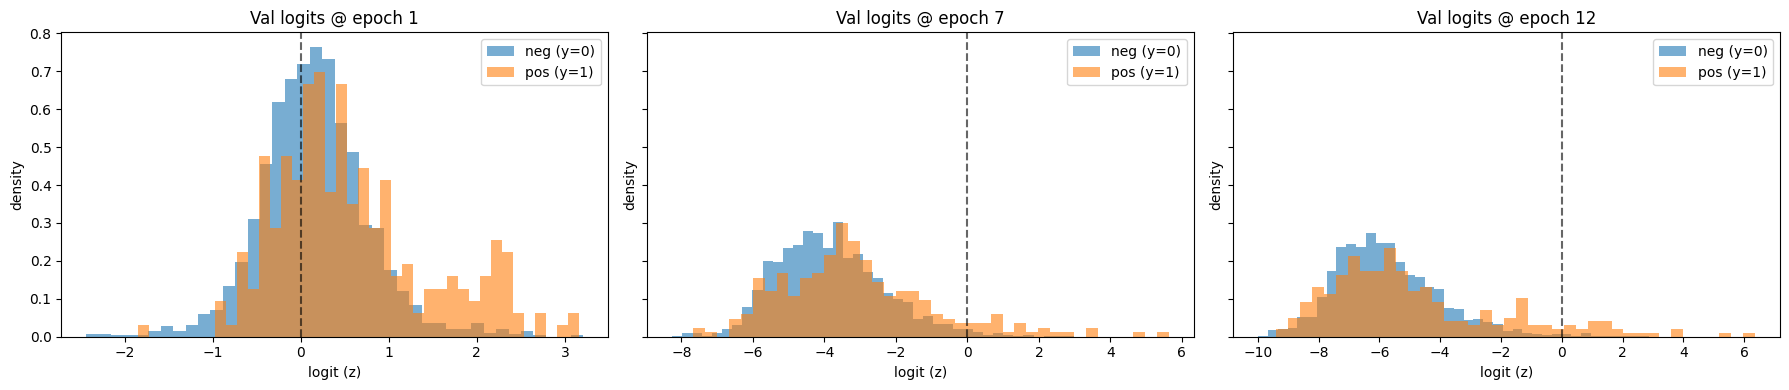

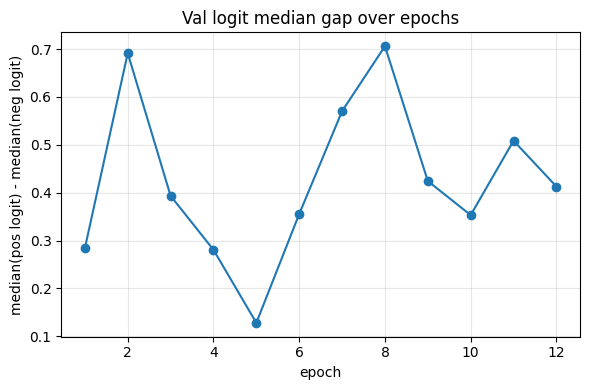

Train Loss,█▇▅▅▃▃▂▂▁▁▁▁
Val AUPR,▁▇██▅▆▆▅▇▅▆▅▆
Val AUROC,▁▆█▇▄▁▃▄▄▁▂▂▁
Val Loss,█▅▁▂▂▁▁▂▂▂▃▂▃
val_logit_gap,▃█▄▃▁▄▆█▅▄▆▄
val_neg_median_logit,█▆▇▇▄▄▃▂▂▁▂▁
val_pos_median_logit,█▆▇▇▄▄▄▃▃▁▂▁
Train Loss,0.00719
Val AUPR,0.22161
Val AUROC,0.56149
Val Loss,0.59102


Training model e2f1ff34-84f8-4143-b57b-ab87f7af8a2f
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 1.2203 | Val Loss 0.5886 | Val AUROC 0.6005 | Val AUPR 0.2111
EPOCH 2 - Train Loss 1.0920 | Val Loss 0.6295 | Val AUROC 0.6172 | Val AUPR 0.2396
EPOCH 3 - Train Loss 1.0097 | Val Loss 0.7456 | Val AUROC 0.6651 | Val AUPR 0.2778
EPOCH 4 - Train Loss 1.0061 | Val Loss 0.5808 | Val AUROC 0.6017 | Val AUPR 0.2436
EPOCH 5 - Train Loss 0.9606 | Val Loss 0.7389 | Val AUROC 0.6182 | Val AUPR 0.2521
EPOCH 6 - Train Loss 0.8970 | Val Loss 0.6163 | Val AUROC 0.5851 | Val AUPR 0.2264
EPOCH 7 - Train Loss 0.8772 | Val Loss 0.5454 | Val AUROC 0.5616 | Val AUPR 0.2072
EPOCH 8 - Train Loss 0.7593 | Val Loss 0.5329 | Val AUROC 0.5911 | Val AUPR 0.2228
EPOCH 9 - Train Loss 0.7158 | Val Loss 0.6446 | Val AUROC 0.6572 | Val AUPR 0.2892
EPOCH 10 - Train Loss 0.6087 | Val Loss 0.6352 | Val AUROC 0.5734 | Val AUPR 0.2191
EPOCH 11 - Train Loss 0.5256 | Val Loss 0.6250

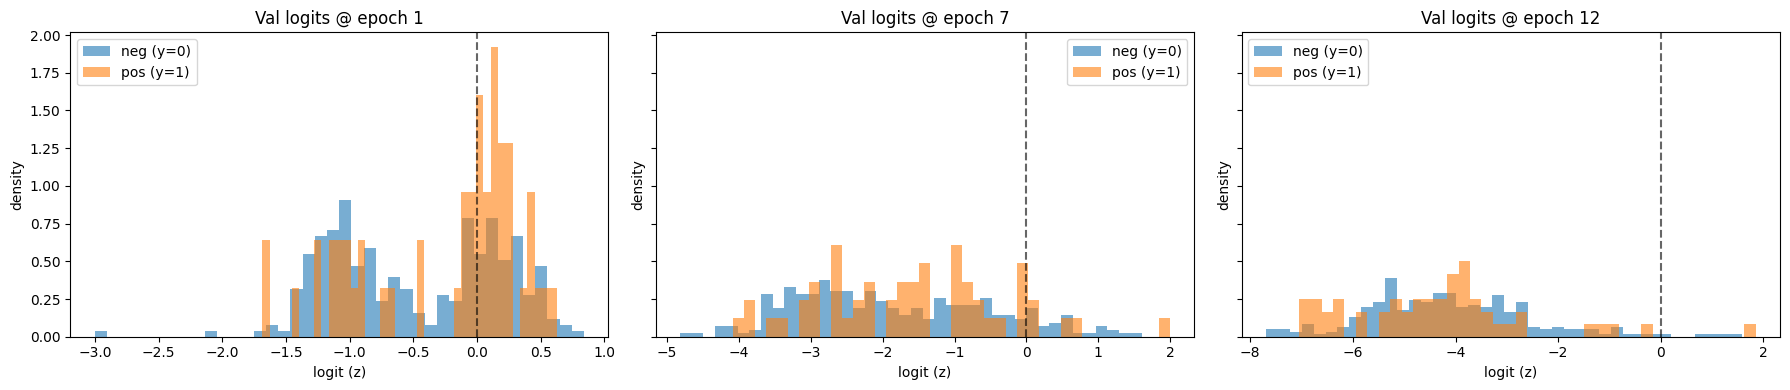

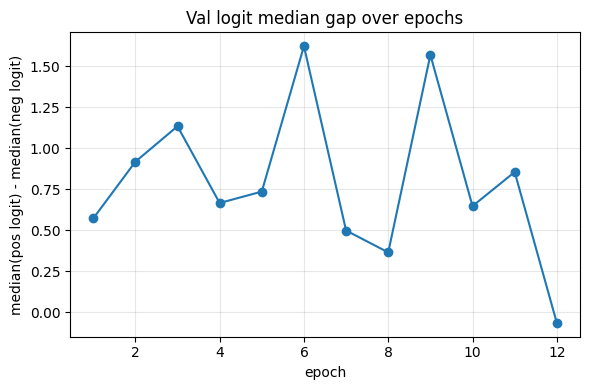

Train Loss,█▇▆▆▆▅▅▄▄▃▂▁
Val AUPR,▅▃▅▇▅▆▄▃▄█▄▅▁
Val AUROC,▆▆▆█▆▆▅▅▆█▅▆▁
Val Loss,█▂▂▄▂▃▂▁▁▂▂▂▄
val_logit_gap,▄▅▆▄▄█▃▃█▄▅▁
val_neg_median_logit,▇██▇█▅▅▅▆▃▃▁
val_pos_median_logit,▇▇█▇▇▆▅▄▇▄▄▁
Train Loss,0.39493
Val AUPR,0.17647
Val AUROC,0.45639
Val Loss,0.80579


Training model e2f1ff34-84f8-4143-b57b-ab87f7af8a2f
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 1.2162 | Val Loss 0.9463 | Val AUROC 0.5890 | Val AUPR 0.1581
EPOCH 2 - Train Loss 1.0870 | Val Loss 1.0660 | Val AUROC 0.5648 | Val AUPR 0.1371
EPOCH 3 - Train Loss 1.0468 | Val Loss 0.8806 | Val AUROC 0.5688 | Val AUPR 0.1485
EPOCH 4 - Train Loss 0.9720 | Val Loss 0.6684 | Val AUROC 0.6144 | Val AUPR 0.1740
EPOCH 5 - Train Loss 0.9430 | Val Loss 0.5680 | Val AUROC 0.5943 | Val AUPR 0.1380
EPOCH 6 - Train Loss 0.8659 | Val Loss 0.8477 | Val AUROC 0.6117 | Val AUPR 0.1766
EPOCH 7 - Train Loss 0.8061 | Val Loss 0.7917 | Val AUROC 0.6017 | Val AUPR 0.1497
EPOCH 8 - Train Loss 0.7443 | Val Loss 1.4723 | Val AUROC 0.6331 | Val AUPR 0.2090
EPOCH 9 - Train Loss 0.7256 | Val Loss 0.5312 | Val AUROC 0.5864 | Val AUPR 0.1762
EPOCH 10 - Train Loss 0.6147 | Val Loss 0.7387 | Val AUROC 0.6229 | Val AUPR 0.1507
EPOCH 11 - Train Loss 0.4814 | Val Loss 0.7437

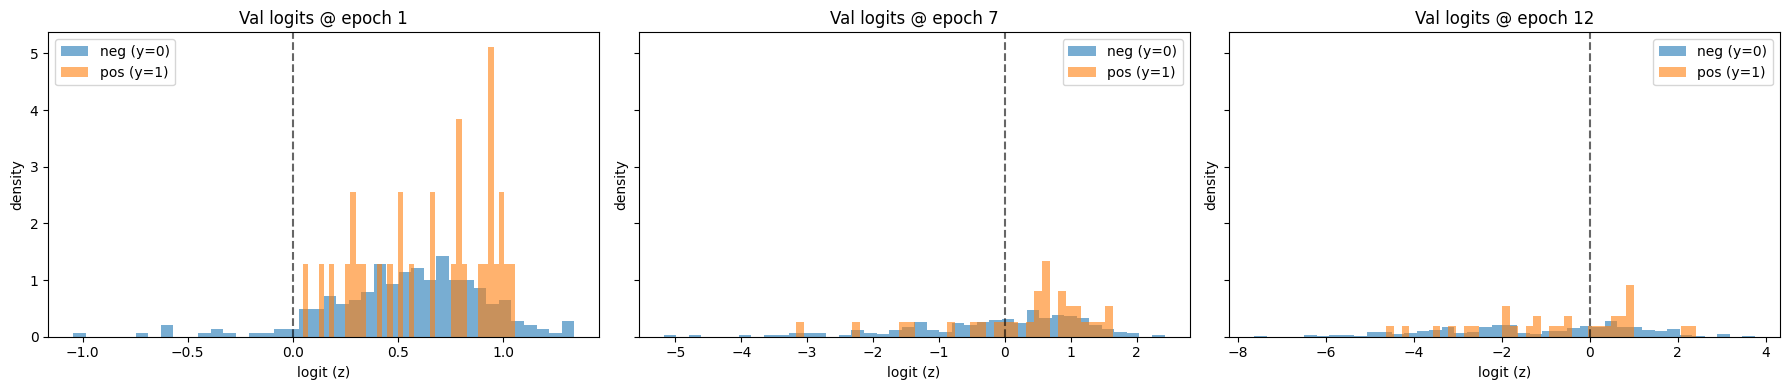

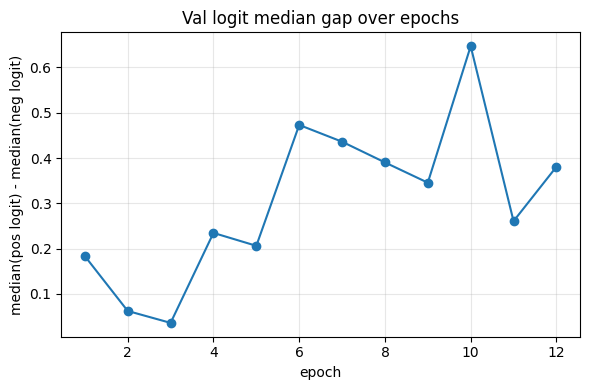

Train Loss,█▇▇▆▆▅▅▄▄▃▂▁
Val AUPR,▅▃▁▂▅▁▅▂█▅▂▂▁
Val AUROC,█▃▂▂▅▄▅▄▆▃▅▁▂
Val Loss,▂▄▅▄▂▁▃▃█▁▃▃▂
val_logit_gap,▃▁▁▃▃▆▆▅▅█▄▅
val_neg_median_logit,▆▆▅▄▃▅▅█▁▃▃▂
val_pos_median_logit,▅▆▅▄▃▅▅█▁▄▂▂
Train Loss,0.36129
Val AUPR,0.13786
Val AUROC,0.56288
Val Loss,0.70781


Split 4: Random oversampling from 2999 to 3000


Training model e2f1ff34-84f8-4143-b57b-ab87f7af8a2f
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 1.1593 | Val Loss 0.4783 | Val AUROC 0.5374 | Val AUPR 0.1141
EPOCH 2 - Train Loss 1.0922 | Val Loss 0.8153 | Val AUROC 0.5283 | Val AUPR 0.0774
EPOCH 3 - Train Loss 0.9783 | Val Loss 0.6947 | Val AUROC 0.5064 | Val AUPR 0.0764
EPOCH 4 - Train Loss 0.9763 | Val Loss 0.7042 | Val AUROC 0.5110 | Val AUPR 0.0723
EPOCH 5 - Train Loss 0.8505 | Val Loss 0.6478 | Val AUROC 0.4616 | Val AUPR 0.0765
EPOCH 6 - Train Loss 0.8391 | Val Loss 0.6798 | Val AUROC 0.4875 | Val AUPR 0.0693
EPOCH 7 - Train Loss 0.8149 | Val Loss 0.6505 | Val AUROC 0.4919 | Val AUPR 0.0759
EPOCH 8 - Train Loss 0.7557 | Val Loss 0.6592 | Val AUROC 0.4832 | Val AUPR 0.0764
EPOCH 9 - Train Loss 0.6632 | Val Loss 0.5700 | Val AUROC 0.4965 | Val AUPR 0.1028
EPOCH 10 - Train Loss 0.5436 | Val Loss 0.5683 | Val AUROC 0.4513 | Val AUPR 0.0748
EPOCH 11 - Train Loss 0.4528 | Val Loss 0.6095

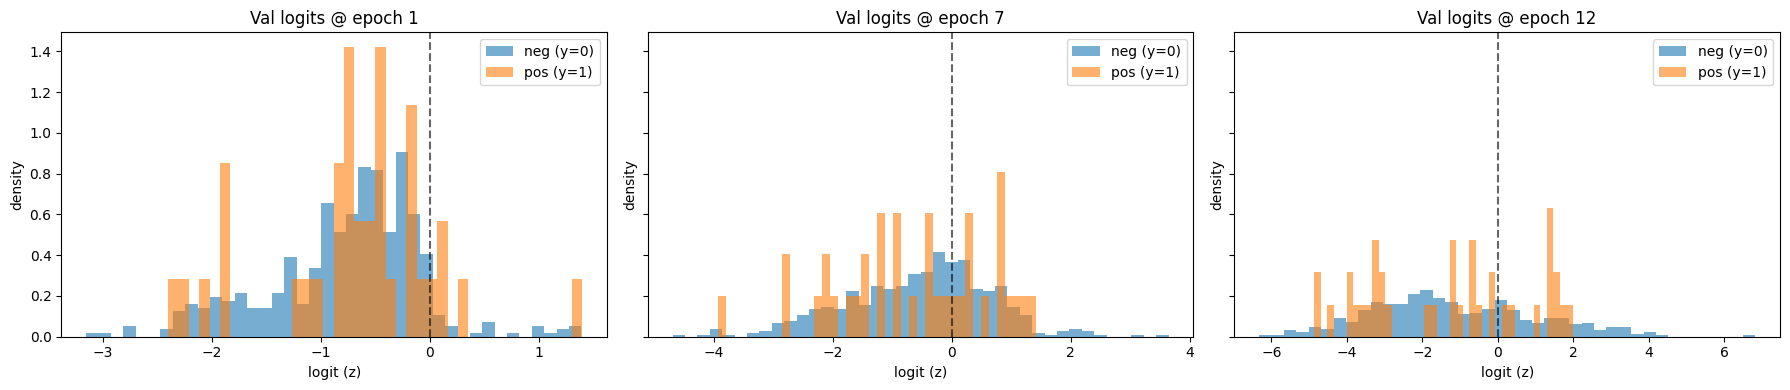

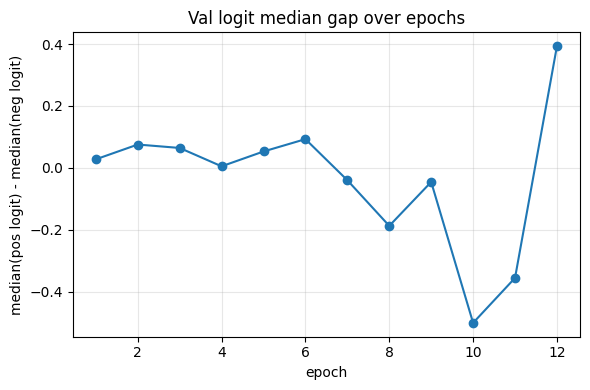

Train Loss,█▇▆▆▅▅▅▄▄▃▂▁
Val AUPR,█▇▂▂▂▂▁▂▂▅▂▁▁
Val AUROC,█▆▅▄▄▂▃▃▃▄▁▁▃
Val Loss,▃▁█▅▆▅▅▅▅▃▃▄▇
val_logit_gap,▅▆▅▅▅▆▅▃▅▁▂█
val_neg_median_logit,▄█▇▇▆▅▅▅▄▂▂▁
val_pos_median_logit,▅█▇▇▆▆▅▅▄▁▁▃
Train Loss,0.3719
Val AUPR,0.06966
Val AUROC,0.48534
Val Loss,0.75021


Training model e2f1ff34-84f8-4143-b57b-ab87f7af8a2f
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 1.1976 | Val Loss 0.9866 | Val AUROC 0.5509 | Val AUPR 0.1312
EPOCH 2 - Train Loss 1.0585 | Val Loss 1.2188 | Val AUROC 0.5707 | Val AUPR 0.1598
EPOCH 3 - Train Loss 1.0412 | Val Loss 0.9245 | Val AUROC 0.5715 | Val AUPR 0.2146
EPOCH 4 - Train Loss 0.9608 | Val Loss 0.6215 | Val AUROC 0.5249 | Val AUPR 0.1533
EPOCH 5 - Train Loss 0.9435 | Val Loss 0.6189 | Val AUROC 0.5610 | Val AUPR 0.1712
EPOCH 6 - Train Loss 0.8801 | Val Loss 0.3899 | Val AUROC 0.5719 | Val AUPR 0.1938
EPOCH 7 - Train Loss 0.7928 | Val Loss 0.5444 | Val AUROC 0.5497 | Val AUPR 0.1444
EPOCH 8 - Train Loss 0.7457 | Val Loss 0.5214 | Val AUROC 0.5486 | Val AUPR 0.2240
EPOCH 9 - Train Loss 0.6668 | Val Loss 1.3947 | Val AUROC 0.5396 | Val AUPR 0.1378
EPOCH 10 - Train Loss 0.6744 | Val Loss 0.4998 | Val AUROC 0.5653 | Val AUPR 0.2000
EPOCH 11 - Train Loss 0.4626 | Val Loss 0.6644

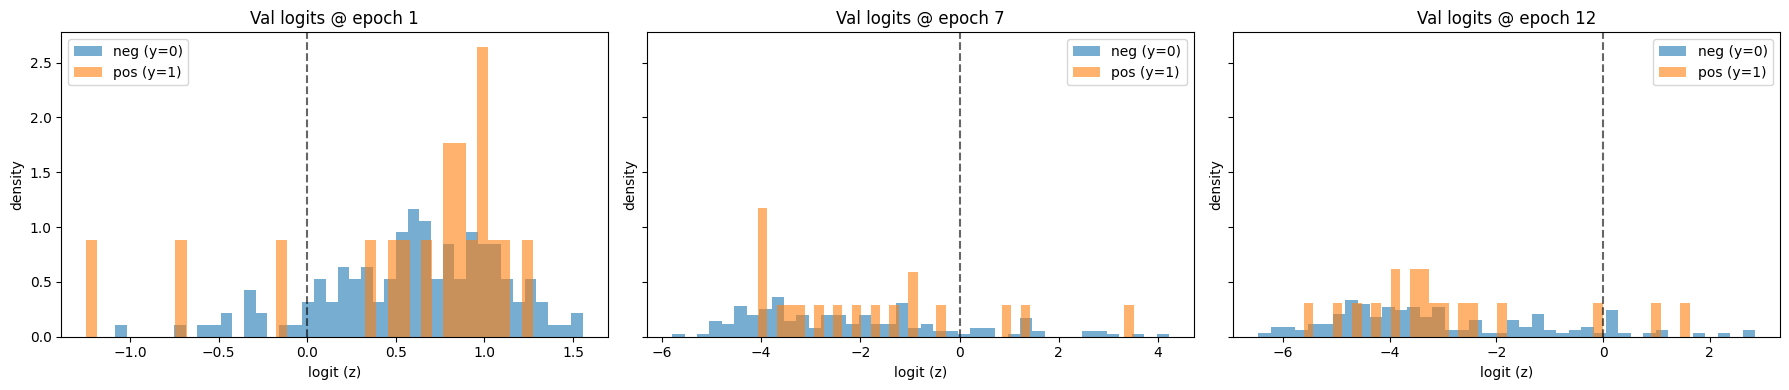

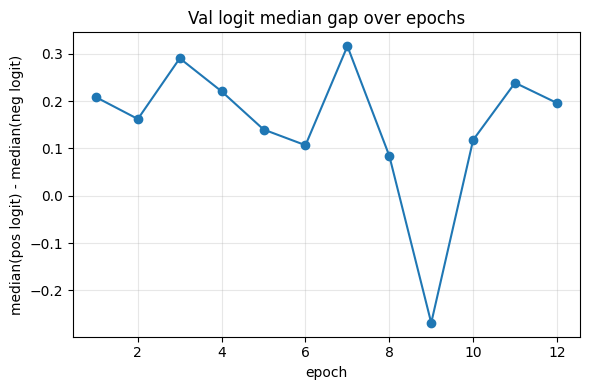

Train Loss,█▇▇▆▆▅▄▄▃▃▁▁
Val AUPR,▁▂▄▇▃▄▆▃█▂▆▁▂
Val AUROC,▂▆██▄▇█▆▆▅▇▁▆
Val Loss,▄▅▇▅▃▃▁▂▂█▂▃▂
val_logit_gap,▇▆█▇▆▅█▅▁▆▇▇
val_neg_median_logit,▇█▇▆▆▄▂▅█▄▂▁
val_pos_median_logit,▇█▇▆▆▄▃▄▇▄▂▁
Train Loss,0.43959
Val AUPR,0.13585
Val AUROC,0.54856
Val Loss,0.48472


In [27]:
batch_size = 20
learning_rate = 2e-5
EPOCHS = 12
g = torch.Generator().manual_seed(SEED)

# login once (env var preferred)
if use_wandb:
    import wandb
    wandb.login()

class PairListDataset(Dataset):
    def __init__(self, examples):
        self.examples = examples

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        b, t, y = self.examples[idx]
        b = torch.as_tensor(b, dtype=torch.float32)
        t = torch.as_tensor(t, dtype=torch.float32)
        y = torch.tensor(float(y), dtype=torch.float32)
        return b, t, y

ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# model.train()

for i in range(len(cv_splits)):
    model = MiniCLIP_w_transformer_crossattn()
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=learning_rate)

    train_targets = cv_splits[i][1]
    train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
    train_raw_list = [ALL_btl[idx] for idx in train_idx] # This is your raw list of (b, t, y)
    
    pos = sum([int(item[2]) for item in train_raw_list])
    neg = len(train_raw_list) - pos
    pos_weight = torch.tensor(neg / max(pos, 1), dtype=torch.float32)

    train_dataset = PairListDataset(train_raw_list)
    
    target_size = 3000
    current_size = len(train_raw_list)
    
    if current_size < target_size:
        print(f"Split {i+1}: Random oversampling from {current_size} to {target_size}")
        sampler = RandomSampler(
            train_dataset, 
            replacement=True, 
            num_samples=target_size
        )
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            sampler=sampler
        )
    else:
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True
        )

    val_targets = cv_splits[i][0]
    val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
    val_raw_list = [ALL_btl[idx] for idx in val_idx]
    val_dataset = PairListDataset(val_raw_list)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    accelerator = Accelerator()
    device = accelerator.device
    model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

    # 8. WandB Logging
    if use_wandb:
        run = wandb.init(
            project="FT_on_meta_weighting_equal_sampling",
            name=f"split{i+1}_Loss_pos_weight",
            group="cv_splits",
            config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
                    "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
        )
        wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
    else:
        run = None

    training_wrapper = TrainWrapper_MetaAnal(
        model=model,
        training_loader=train_loader,
        validation_loader=val_loader,
        test_dataset=val_dataset,
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        runID=runID,
        device=device,
        model_save_steps=model_save_steps,
        model_save_path=trained_model_dir,
        v=True,
        wandb_tracker=run,
        split_id=i+1,
        pos_weight=pos_weight # Passed to the wrapper for criterion setup
    )
    training_wrapper.train_model()

    # 10. Cleanup
    if use_wandb:
        wandb.finish()
    del training_wrapper, model, optimizer, train_loader, val_loader
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    try:
        accelerator.free_memory()
    except AttributeError:
        pass

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 1.1936 | Val AUROC 0.5581 | Val AUPR 0.1265
EPOCH 1 - Train Loss 1.3480 | Val Loss 0.8235 | Val AUROC 0.6258 | Val AUPR 0.2526
EPOCH 2 - Train Loss 1.1243 | Val Loss 0.7888 | Val AUROC 0.6397 | Val AUPR 0.2577
EPOCH 3 - Train Loss 1.0901 | Val Loss 0.5312 | Val AUROC 0.6707 | Val AUPR 0.2700
EPOCH 4 - Train Loss 0.9810 | Val Loss 0.5578 | Val AUROC 0.6422 | Val AUPR 0.2121
EPOCH 5 - Train Loss 0.9472 | Val Loss 1.2485 | Val AUROC 0.6276 | Val AUPR 0.2617
EPOCH 6 - Train Loss 0.8555 | Val Loss 0.4655 | Val AUROC 0.6174 | Val AUPR 0.2340
EPOCH 7 - Train Loss 0.7342 | Val Loss 0.5797 | Val AUROC 0.5956 | Val AUPR 0.1488
EPOCH 8 - Train Loss 0.7149 | Val Loss 0.5850 | Val AUROC 0.6560 | Val AUPR 0.2430
EPOCH 9 - Train Loss 0.5353 | Val Loss 0.4304 | Val AUROC 0.5948 | Val AUPR 0.2412
EPOCH 10 - Train Loss 0.5994 | Val Loss 0.5376 | Val AUROC 0.6226 | Val AUPR 0.2045
EPOCH 11 - Train Loss 0.4188 | Val Loss 0.4200

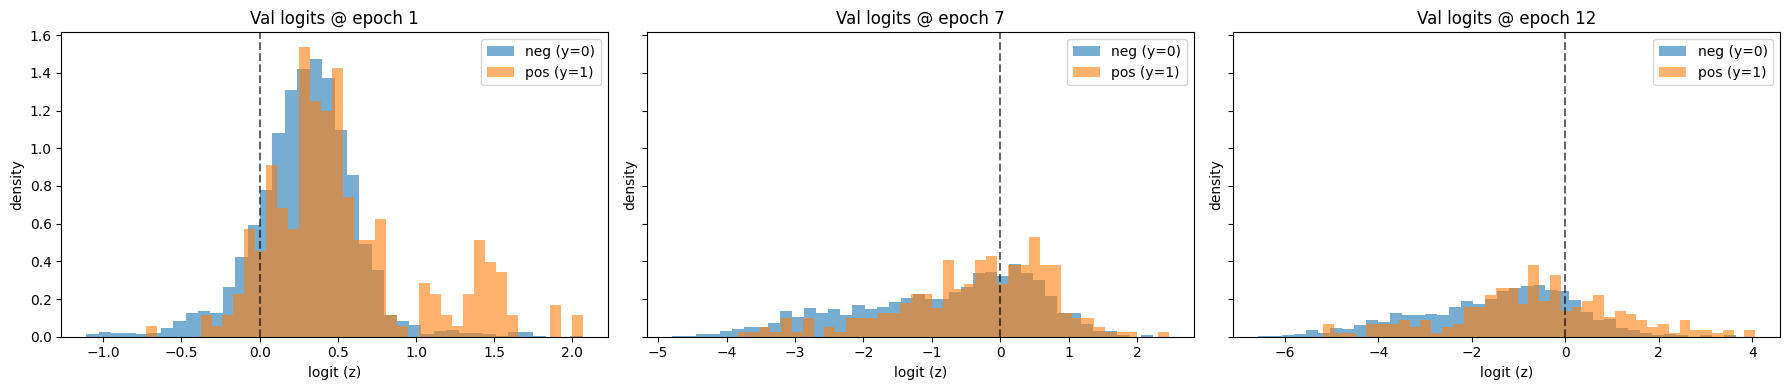

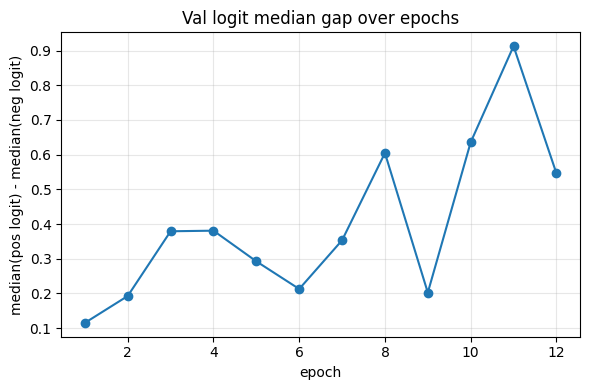

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 1.1206 | Val AUROC 0.6058 | Val AUPR 0.2369
EPOCH 1 - Train Loss 1.2290 | Val Loss 0.5844 | Val AUROC 0.5819 | Val AUPR 0.2003
EPOCH 2 - Train Loss 1.0952 | Val Loss 0.6106 | Val AUROC 0.5991 | Val AUPR 0.2300
EPOCH 3 - Train Loss 1.0119 | Val Loss 0.7240 | Val AUROC 0.6697 | Val AUPR 0.2921
EPOCH 4 - Train Loss 1.0135 | Val Loss 0.5922 | Val AUROC 0.6063 | Val AUPR 0.2384
EPOCH 5 - Train Loss 0.9650 | Val Loss 0.7198 | Val AUROC 0.6098 | Val AUPR 0.2372
EPOCH 6 - Train Loss 0.8986 | Val Loss 0.5951 | Val AUROC 0.5696 | Val AUPR 0.2068
EPOCH 7 - Train Loss 0.8845 | Val Loss 0.5556 | Val AUROC 0.5539 | Val AUPR 0.1937
EPOCH 8 - Train Loss 0.7646 | Val Loss 0.5472 | Val AUROC 0.5838 | Val AUPR 0.2051
EPOCH 9 - Train Loss 0.7107 | Val Loss 0.6139 | Val AUROC 0.6574 | Val AUPR 0.2757
EPOCH 10 - Train Loss 0.5943 | Val Loss 0.6191 | Val AUROC 0.6192 | Val AUPR 0.2428
EPOCH 11 - Train Loss 0.5272 | Val Loss 0.6009

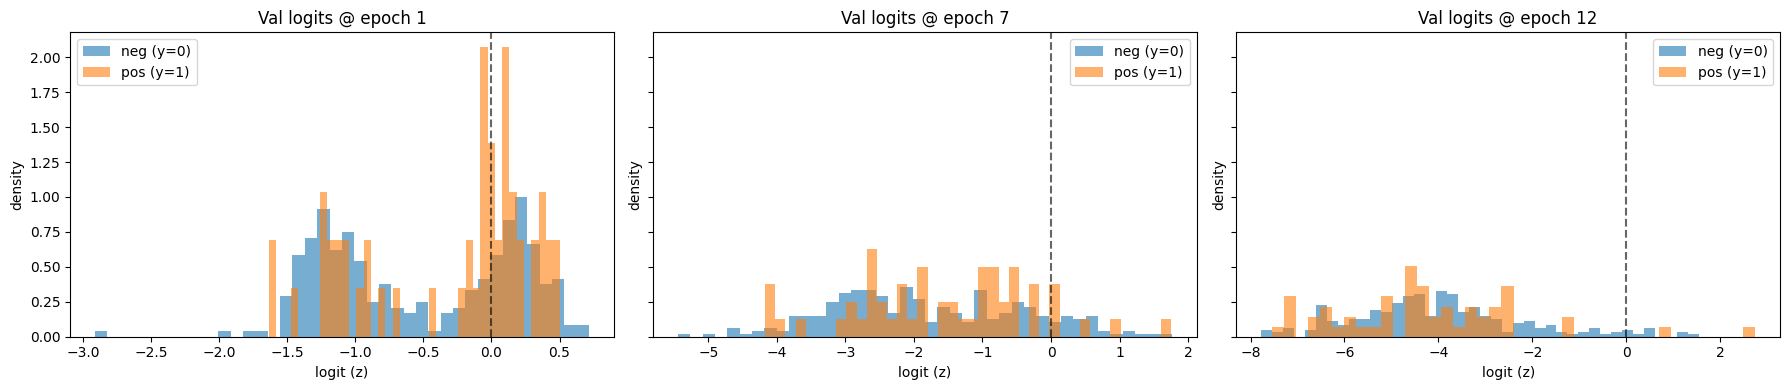

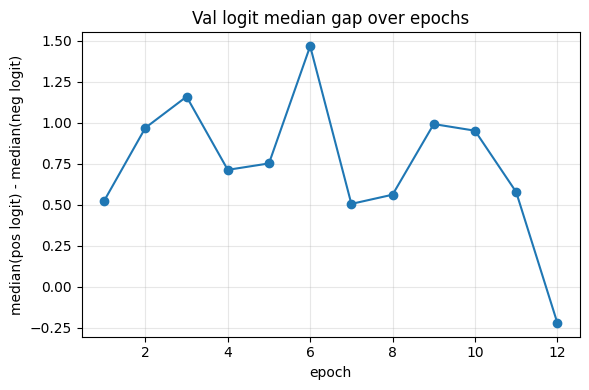

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 0.7167 | Val AUROC 0.6781 | Val AUPR 0.1806
EPOCH 1 - Train Loss 1.2163 | Val Loss 0.8872 | Val AUROC 0.6139 | Val AUPR 0.1783
EPOCH 2 - Train Loss 1.0860 | Val Loss 1.0347 | Val AUROC 0.5772 | Val AUPR 0.1411
EPOCH 3 - Train Loss 1.0448 | Val Loss 0.9370 | Val AUROC 0.5685 | Val AUPR 0.1534
EPOCH 4 - Train Loss 0.9741 | Val Loss 0.6829 | Val AUROC 0.6046 | Val AUPR 0.1795
EPOCH 5 - Train Loss 0.9353 | Val Loss 0.6086 | Val AUROC 0.5252 | Val AUPR 0.1174
EPOCH 6 - Train Loss 0.8626 | Val Loss 0.8363 | Val AUROC 0.6039 | Val AUPR 0.1778
EPOCH 7 - Train Loss 0.7954 | Val Loss 0.7682 | Val AUROC 0.6184 | Val AUPR 0.1625
EPOCH 8 - Train Loss 0.7403 | Val Loss 1.3778 | Val AUROC 0.6084 | Val AUPR 0.1668
EPOCH 9 - Train Loss 0.7178 | Val Loss 0.5637 | Val AUROC 0.5599 | Val AUPR 0.1641
EPOCH 10 - Train Loss 0.6064 | Val Loss 0.7163 | Val AUROC 0.5988 | Val AUPR 0.1437
EPOCH 11 - Train Loss 0.4717 | Val Loss 0.6260

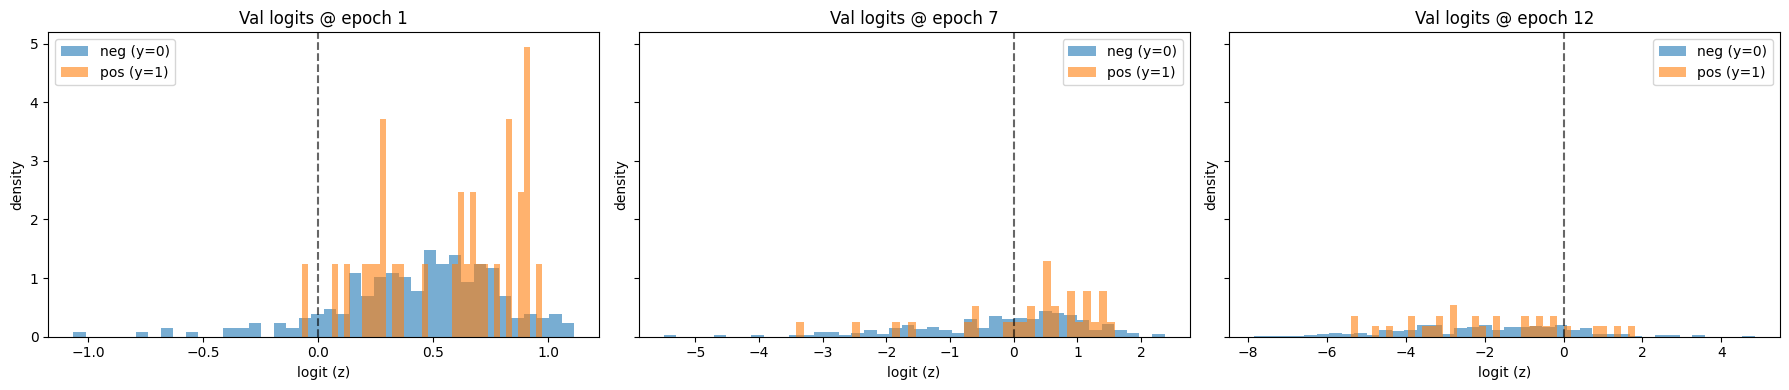

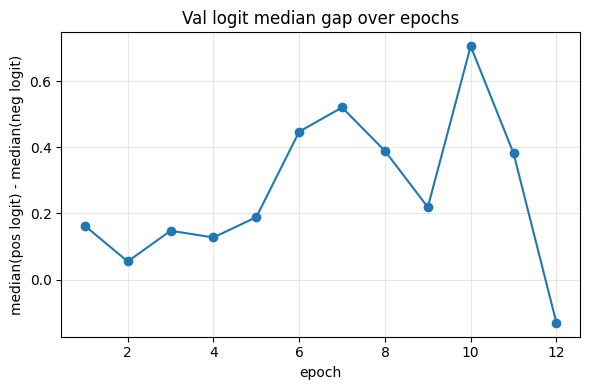

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 0.5645 | Val AUROC 0.5779 | Val AUPR 0.1244
EPOCH 1 - Train Loss 1.1847 | Val Loss 1.0207 | Val AUROC 0.4997 | Val AUPR 0.1189
EPOCH 2 - Train Loss 1.0666 | Val Loss 0.5166 | Val AUROC 0.5301 | Val AUPR 0.0768
EPOCH 3 - Train Loss 1.0360 | Val Loss 1.0355 | Val AUROC 0.5106 | Val AUPR 0.0790
EPOCH 4 - Train Loss 1.0155 | Val Loss 0.9720 | Val AUROC 0.5503 | Val AUPR 0.0799
EPOCH 5 - Train Loss 0.9732 | Val Loss 0.7227 | Val AUROC 0.5484 | Val AUPR 0.0852
EPOCH 6 - Train Loss 0.9022 | Val Loss 0.6946 | Val AUROC 0.5215 | Val AUPR 0.0758
EPOCH 7 - Train Loss 0.8348 | Val Loss 0.7067 | Val AUROC 0.4871 | Val AUPR 0.0818
EPOCH 8 - Train Loss 0.7613 | Val Loss 0.5710 | Val AUROC 0.5194 | Val AUPR 0.0758
EPOCH 9 - Train Loss 0.6719 | Val Loss 0.6414 | Val AUROC 0.5554 | Val AUPR 0.0922
EPOCH 10 - Train Loss 0.5874 | Val Loss 0.4902 | Val AUROC 0.4820 | Val AUPR 0.0707
EPOCH 11 - Train Loss 0.4734 | Val Loss 0.5969

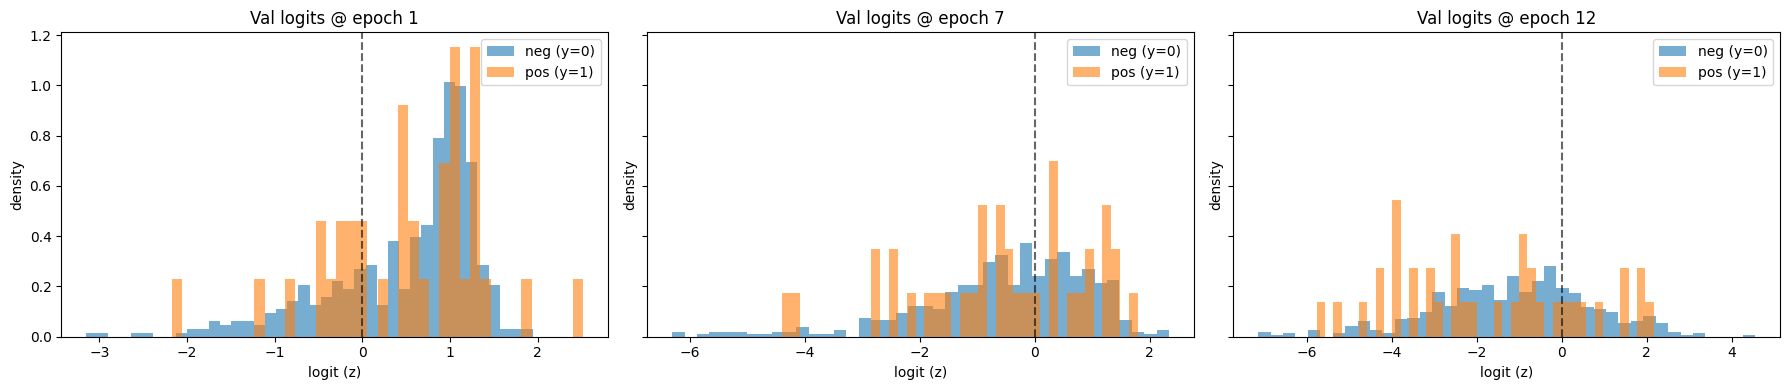

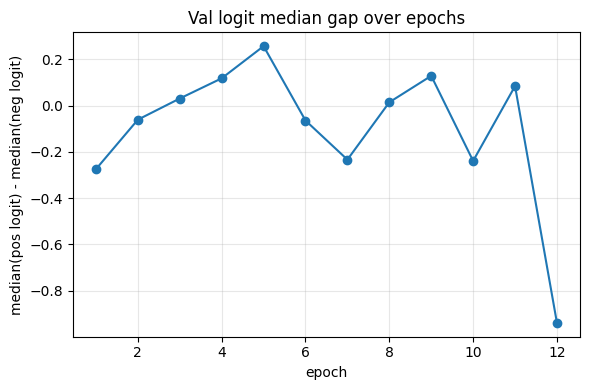

Training model 8ee9b35b-61e8-467f-9025-94ed4e3b8d9a
Before training - Val Loss 0.8068 | Val AUROC 0.5047 | Val AUPR 0.1241
EPOCH 1 - Train Loss 1.1940 | Val Loss 1.0085 | Val AUROC 0.5548 | Val AUPR 0.1311
EPOCH 2 - Train Loss 1.0559 | Val Loss 1.2511 | Val AUROC 0.5680 | Val AUPR 0.2120
EPOCH 3 - Train Loss 1.0376 | Val Loss 0.8149 | Val AUROC 0.5653 | Val AUPR 0.2391
EPOCH 4 - Train Loss 0.9569 | Val Loss 0.5761 | Val AUROC 0.5109 | Val AUPR 0.1487
EPOCH 5 - Train Loss 0.9381 | Val Loss 0.6212 | Val AUROC 0.5567 | Val AUPR 0.1810
EPOCH 6 - Train Loss 0.8810 | Val Loss 0.3760 | Val AUROC 0.5715 | Val AUPR 0.1919
EPOCH 7 - Train Loss 0.7929 | Val Loss 0.4517 | Val AUROC 0.5692 | Val AUPR 0.1492
EPOCH 8 - Train Loss 0.7520 | Val Loss 0.5747 | Val AUROC 0.5862 | Val AUPR 0.1622
EPOCH 9 - Train Loss 0.6616 | Val Loss 1.5461 | Val AUROC 0.5264 | Val AUPR 0.1864
EPOCH 10 - Train Loss 0.6621 | Val Loss 0.4146 | Val AUROC 0.5668 | Val AUPR 0.2374
EPOCH 11 - Train Loss 0.4941 | Val Loss 0.5927

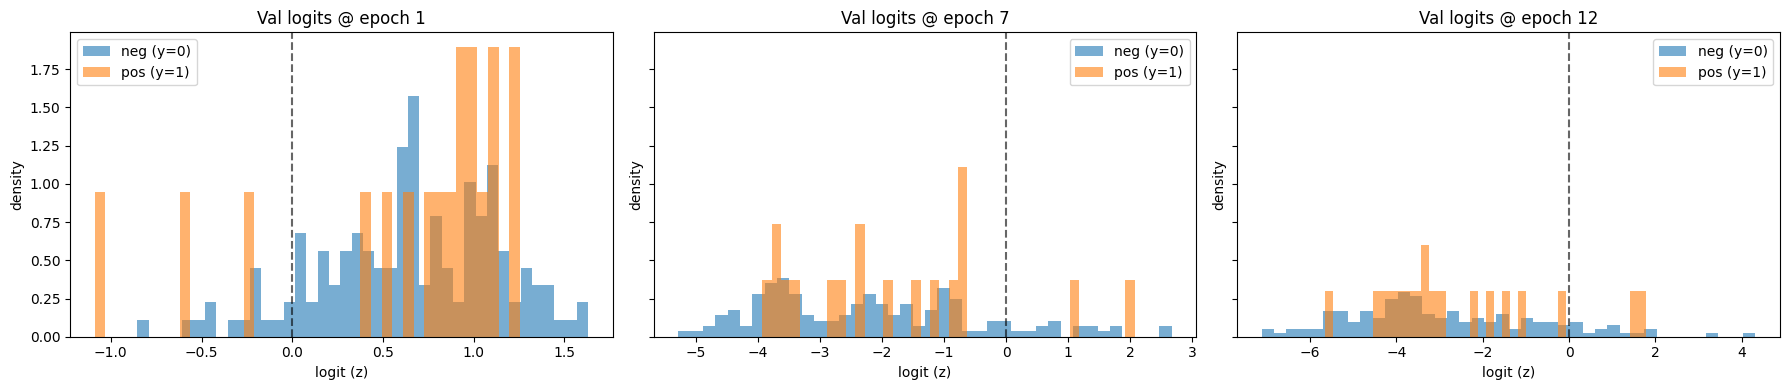

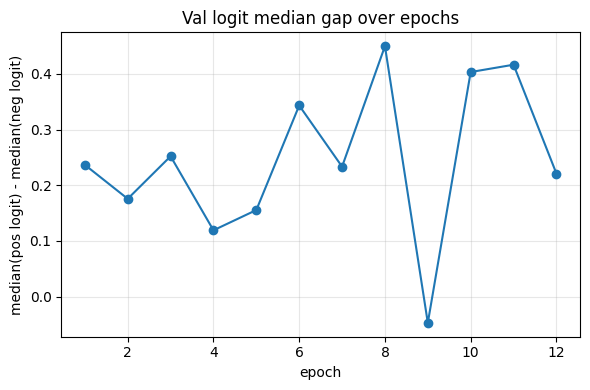

In [28]:
# batch_size = 20
# learning_rate = 2e-5
# EPOCHS = 12
# g = torch.Generator().manual_seed(SEED)

# # login once (env var preferred)
# if use_wandb:
#     import wandb
#     wandb.login()

# class PairListDataset(Dataset):
#     def __init__(self, examples):
#         self.examples = examples

#     def __len__(self):
#         return len(self.examples)

#     def __getitem__(self, idx):
#         b, t, y = self.examples[idx]
#         b = torch.as_tensor(b, dtype=torch.float32)
#         t = torch.as_tensor(t, dtype=torch.float32)
#         y = torch.tensor(float(y), dtype=torch.float32)
#         return b, t, y

# ckpt_path = '../PPI_PLM/models/CLIP_no_structural_information/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_4/a1d0549b-3f90-4ce2-b795-7bca2276cb07_checkpoint_epoch_4.pth'
# checkpoint = torch.load(ckpt_path, weights_only=False, map_location="cpu")
# # model.train()

# for i in range(len(cv_splits)):
#     # NEW model per split
#     model = MiniCLIP_w_transformer_crossattn()
#     model.load_state_dict(checkpoint['model_state_dict'])
#     model.to(device)
#     optimizer = AdamW(model.parameters(), lr=learning_rate)

#     # validation
#     val_targets = cv_splits[i][0]
#     val_idx = interaction_df.loc[interaction_df.target_id_mod.isin(val_targets)].index.tolist()
#     val_binders = [ALL_btl[idx] for idx in val_idx]
#     val_binders = PairListDataset(val_binders)

#     # training
#     train_targets = cv_splits[i][1]
#     train_idx = interaction_df.loc[interaction_df.target_id_mod.isin(train_targets)].index.tolist()
#     train_binders = [ALL_btl[idx] for idx in train_idx]
#     train_binders = PairListDataset(train_binders)

#     # loaders
#     ### no weighting
#     train_loader   = DataLoader(train_binders, batch_size=20, shuffle=True)
#     val_loader   = DataLoader(val_binders,   batch_size=20, shuffle=False, drop_last = False)

#     pos = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 1])
#     neg = len([int(i[2].numpy()) for i in train_binders if int(i[2].numpy()) == 0])
#     pos_weight = torch.tensor(neg / max(pos, 1))

#     # accelerator
#     accelerator = Accelerator()
#     device = accelerator.device
#     model, optimizer, train_loader, val_loader = accelerator.prepare(model, optimizer, train_loader, val_loader)

#     # wandb
#     if use_wandb:
#         run = wandb.init(
#             project="FT_on_meta_weighting",
#             name=f"split{i+1}_Loss_pos_weight",
#             group="cv_splits",
#             config={"learning_rate": learning_rate, "batch_size": batch_size, "epochs": EPOCHS,
#                     "architecture": "MiniCLIP_w_transformer_crossattn", "dataset": "Meta analysis"},
#         )
#         wandb.watch(accelerator.unwrap_model(model), log="all", log_freq=100)
#     else:
#         run = None

#     # train
#     training_wrapper = TrainWrapper_MetaAnal(
#         model=model,
#         training_loader=train_loader,
#         validation_loader=val_loader,
#         test_dataset=val_binders,   # ok if you truly want “full val”
#         optimizer=optimizer,
#         EPOCHS=EPOCHS,
#         runID=runID,
#         device=device,
#         model_save_steps=model_save_steps,
#         model_save_path=trained_model_dir,
#         v=True,
#         wandb_tracker=run,
#         split_id=i+1
#     )
#     training_wrapper.train_model()

#     # cleanup between splits
#     if use_wandb:
#         wandb.finish()
#     del training_wrapper, model, optimizer, train_loader, val_loader
#     if torch.cuda.is_available():
#         torch.cuda.empty_cache()
#     try:
#         accelerator.free_memory()
#     except AttributeError:
#         pass

In [ ]:
results_lists = {
  "class_w": {
    "Fold1": {
      "AUROC": [0.5554, 0.6577, 0.6578, 0.6713, 0.6645, 0.6333],
      "AUPR":  [0.1251, 0.2138, 0.2137, 0.2330, 0.2501, 0.2206],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6123, 0.5477, 0.6103, 0.5774, 0.5651],
      "AUPR":  [0.2373, 0.2166, 0.2431, 0.2382, 0.2077, 0.2183],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6303, 0.6413, 0.6031, 0.6344, 0.5109],
      "AUPR":  [0.1795, 0.2207, 0.2023, 0.1702, 0.2134, 0.1392],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5438, 0.5277, 0.5013, 0.5152, 0.4682],
      "AUPR":  [0.1247, 0.0821, 0.0761, 0.0808, 0.0847, 0.0698],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.4592, 0.5350, 0.5750, 0.5342, 0.5458],
      "AUPR":  [0.1242, 0.1989, 0.1831, 0.1947, 0.1537, 0.1803],
    },
  },

  "class_target_w": {
    "Fold1": {
      "AUROC": [0.5554, 0.6583, 0.5939, 0.5873, 0.6199, 0.6047],
      "AUPR":  [0.1251, 0.1969, 0.2156, 0.2185, 0.1636, 0.1930],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.4950, 0.5602, 0.5400, 0.5418, 0.4352],
      "AUPR":  [0.2373, 0.1594, 0.1949, 0.1823, 0.1962, 0.1650],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6361, 0.5999, 0.6562, 0.6062, 0.5858],
      "AUPR":  [0.1795, 0.1865, 0.1435, 0.1802, 0.1776, 0.1603],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.6017, 0.5515, 0.5456, 0.5156, 0.5471],
      "AUPR":  [0.1247, 0.0894, 0.0812, 0.0736, 0.0723, 0.0772],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5385, 0.5260, 0.6014, 0.5637, 0.5882],
      "AUPR":  [0.1242, 0.2128, 0.1613, 0.2095, 0.2235, 0.2192],
    },
  },

  "loss_w": {
    "Fold1": {
      "AUROC": [0.5554, 0.5977, 0.6268, 0.6730, 0.6777, 0.6310],
      "AUPR":  [0.1251, 0.2153, 0.2230, 0.2472, 0.2646, 0.2213],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6178, 0.6317, 0.6403, 0.6447, 0.5810],
      "AUPR":  [0.2373, 0.2321, 0.2488, 0.2495, 0.2814, 0.2185],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.5627, 0.6095, 0.6191, 0.5996, 0.6208],
      "AUPR":  [0.1795, 0.1348, 0.1636, 0.2071, 0.1909, 0.1671],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5210, 0.5616, 0.5517, 0.5361, 0.5512],
      "AUPR":  [0.1247, 0.0862, 0.1057, 0.0773, 0.0790, 0.0758],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5361, 0.5198, 0.5493, 0.5291, 0.5723],
      "AUPR":  [0.1242, 0.1759, 0.1393, 0.1554, 0.1464, 0.1445],
    },
  },

  "order": ["Before", "E1", "E2", "E3", "E4", "E5"],
}

In [ ]:
metrics_class_w = {
    "Fold1": {
      "AUROC": [0.5554, 0.6577, 0.6578, 0.6713, 0.6645, 0.6333],
      "AUPR":  [0.1251, 0.2138, 0.2137, 0.2330, 0.2501, 0.2206],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6123, 0.5477, 0.6103, 0.5774, 0.5651],
      "AUPR":  [0.2373, 0.2166, 0.2431, 0.2382, 0.2077, 0.2183],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6303, 0.6413, 0.6031, 0.6344, 0.5109],
      "AUPR":  [0.1795, 0.2207, 0.2023, 0.1702, 0.2134, 0.1392],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5438, 0.5277, 0.5013, 0.5152, 0.4682],
      "AUPR":  [0.1247, 0.0821, 0.0761, 0.0808, 0.0847, 0.0698],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.4592, 0.5350, 0.5750, 0.5342, 0.5458],
      "AUPR":  [0.1242, 0.1989, 0.1831, 0.1947, 0.1537, 0.1803],
    },
}

metrics_class_target_w = {
    "Fold1": {
      "AUROC": [0.5554, 0.6583, 0.5939, 0.5873, 0.6199, 0.6047],
      "AUPR":  [0.1251, 0.1969, 0.2156, 0.2185, 0.1636, 0.1930],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.4950, 0.5602, 0.5400, 0.5418, 0.4352],
      "AUPR":  [0.2373, 0.1594, 0.1949, 0.1823, 0.1962, 0.1650],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.6361, 0.5999, 0.6562, 0.6062, 0.5858],
      "AUPR":  [0.1795, 0.1865, 0.1435, 0.1802, 0.1776, 0.1603],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.6017, 0.5515, 0.5456, 0.5156, 0.5471],
      "AUPR":  [0.1247, 0.0894, 0.0812, 0.0736, 0.0723, 0.0772],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5385, 0.5260, 0.6014, 0.5637, 0.5882],
      "AUPR":  [0.1242, 0.2128, 0.1613, 0.2095, 0.2235, 0.2192],
    },
  }

metrics_loss_w = {
    "Fold1": {
      "AUROC": [0.5554, 0.5977, 0.6268, 0.6730, 0.6777, 0.6310],
      "AUPR":  [0.1251, 0.2153, 0.2230, 0.2472, 0.2646, 0.2213],
    },
    "Fold2": {
      "AUROC": [0.6068, 0.6178, 0.6317, 0.6403, 0.6447, 0.5810],
      "AUPR":  [0.2373, 0.2321, 0.2488, 0.2495, 0.2814, 0.2185],
    },
    "Fold3": {
      "AUROC": [0.6763, 0.5627, 0.6095, 0.6191, 0.5996, 0.6208],
      "AUPR":  [0.1795, 0.1348, 0.1636, 0.2071, 0.1909, 0.1671],
    },
    "Fold4": {
      "AUROC": [0.5781, 0.5210, 0.5616, 0.5517, 0.5361, 0.5512],
      "AUPR":  [0.1247, 0.0862, 0.1057, 0.0773, 0.0790, 0.0758],
    },
    "Fold5": {
      "AUROC": [0.5035, 0.5361, 0.5198, 0.5493, 0.5291, 0.5723],
      "AUPR":  [0.1242, 0.1759, 0.1393, 0.1554, 0.1464, 0.1445],
    },
  }

In [ ]:
epochs = list(range(1, 7))

plt.figure(figsize=(10, 4))

# -----------------------
# Subplot 1: AUROC
# -----------------------
plt.subplot(1, 2, 1)
for fold, vals in metrics_loss_w.items():
    plt.plot(epochs, vals["AUROC"], marker='o', label=fold)

plt.title("Fine-tunning on 'meta-analysis' dataset \n Loss weighting")
plt.xlabel("Epoch")
plt.ylabel("AUROC")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()

# -----------------------
# Subplot 2: AUPR
# -----------------------
plt.subplot(1, 2, 2)
for fold, vals in metrics_loss_w.items():
    plt.plot(epochs, vals["AUPR"], marker='o', label=fold)

plt.title("Fine-tunning on 'meta-analysis' dataset \n Loss weighting")
plt.xlabel("Epoch")
plt.ylabel("AUPR")
plt.ylim(0, 1)
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from scipy import stats
from itertools import combinations

SCHEMES = ["class_w", "class_target_w", "loss_w"]
METRICS = ["AUROC", "AUPR"]
EPOCH_IDX = [1, 2, 3, 4, 5]  # ignore index 0 ("Before")
ALPHA = 0.05

def per_fold_epoch_mean(results, scheme, metric):
    """Return a dict: fold -> mean over E1..E5 for the given scheme/metric."""
    fold_means = {}
    for fold, vals in results[scheme].items():
        scores = vals[metric]
        # scores[0] is "Before", so average over indices 1..5
        epoch_scores = [scores[i] for i in range(1, 6)]
        fold_means[fold] = float(np.mean(epoch_scores))
    return fold_means

def collect_means_df(results):
    """DataFrame with columns: scheme, fold, AUROC_mean, AUPR_mean (averaged over E1..E5)."""
    rows = []
    # intersect folds across schemes just in case
    folds_sets = [set(results[s].keys()) for s in SCHEMES]
    common_folds = sorted(set.intersection(*folds_sets))
    for scheme in SCHEMES:
        auroc_means = per_fold_epoch_mean(results, scheme, "AUROC")
        aupr_means  = per_fold_epoch_mean(results, scheme, "AUPR")
        for fold in common_folds:
            rows.append({
                "scheme": scheme,
                "fold": fold,
                "AUROC_mean": auroc_means[fold],
                "AUPR_mean": aupr_means[fold],
            })
    return pd.DataFrame(rows)

def paired_tests_with_bonferroni(df, metric):
    """Paired t-tests across folds for the given metric (e.g., 'AUROC_mean')."""
    metric_col = f"{metric}_mean"
    # build fold-aligned vectors per scheme
    fold_order = sorted(df["fold"].unique())
    vectors = {
        scheme: df[df["scheme"] == scheme].set_index("fold").loc[fold_order, metric_col].values
        for scheme in SCHEMES
    }
    # 3 pairwise comparisons
    pairs = list(combinations(SCHEMES, 2))
    m = len(pairs)  # Bonferroni factor = 3
    out = []
    for a, b in pairs:
        x, y = vectors[a], vectors[b]
        tstat, p_raw = stats.ttest_rel(x, y, nan_policy="raise")
        p_adj = min(p_raw * m, 1.0)
        # simple paired Cohen's d (dz)
        diff = x - y
        dz = diff.mean() / (diff.std(ddof=1) + 1e-12)
        out.append({
            "metric": metric,
            "comparison": f"{a} vs {b}",
            "n_folds": len(x),
            "t": tstat,
            "p_raw": p_raw,
            "p_bonf": p_adj,
            "signif_0.05": p_adj < ALPHA,
            "mean_a": x.mean(),
            "mean_b": y.mean(),
            "mean_diff_a_minus_b": (x - y).mean(),
            "cohens_dz": dz,
        })
    return pd.DataFrame(out).sort_values("p_bonf")

def descriptive_table(df):
    """Per-scheme summary of fold-averaged means (mean ± std across folds)."""
    summaries = []
    for scheme, g in df.groupby("scheme"):
        summaries.append({
            "scheme": scheme,
            "AUROC_mean_over_folds": g["AUROC_mean"].mean(),
            "AUROC_std_over_folds": g["AUROC_mean"].std(ddof=1),
            "AUPR_mean_over_folds": g["AUPR_mean"].mean(),
            "AUPR_std_over_folds": g["AUPR_mean"].std(ddof=1),
        })
    return pd.DataFrame(summaries).sort_values("AUROC_mean_over_folds", ascending=False)

# ---- Run analysis ----
df_means = collect_means_df(results_lists)

desc = descriptive_table(df_means)
print("\nPer-scheme descriptive stats (averaged over E1..E5, then summarized across folds):")
print(desc.to_string(index=False))

auroc_tests = paired_tests_with_bonferroni(df_means, "AUROC")
aupr_tests  = paired_tests_with_bonferroni(df_means, "AUPR")

print("\nPaired t-tests with Bonferroni (AUROC):")
print(auroc_tests.to_string(index=False))

print("\nPaired t-tests with Bonferroni (AUPR):")
print(aupr_tests.to_string(index=False))
